## Trabalho de Econometria - Análise sobre preço de CDS 
#### Diogo Sánchez

In [1]:

if True: #Importando os pacotes
    import pandas as pd
    import numpy as np 
    import warnings

    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib.transforms import Bbox

    from IPython.display import display,clear_output

    import yfinance as yf

    from statsmodels.graphics.tsaplots import plot_pacf,plot_acf 
    from scipy.stats import norm

    from statsmodels.tsa.arima.model import ARIMA
    from statsmodels.tsa.api import VAR
    import statsmodels.formula.api as smf 
    from sklearn.metrics import mean_squared_error
    import statsmodels.api as sm
    from statsmodels.tsa.stattools import adfuller
    from scipy.stats import ttest_ind

if True: # Definindo funções
    def plot_generalizado(base , contraparte):

        
        plt.figure(figsize=(15,5))
        retorno = base[base['Nome'] == contraparte]
        periodos = retorno['Duracao'].unique()
        for i in periodos:
            sub_retorno = retorno[retorno['Duracao'] == i]
            plt.plot(sub_retorno['Data'],sub_retorno['Preço'],label=i + " Years")
        plt.legend()
        plt.title(contraparte + ' - CDS Historic Price')
        plt.show()
        return retorno.sort_values('Data')

    def plot_acf_pacf(x,figsize_=(15,5),title=None):

        acf_ = sm.tsa.acf(x)
        pacf_ = sm.tsa.pacf(x)
        tamanho = len(acf_)

        fig , ax = plt.subplots(1,2,figsize=figsize_)
        df = pd.DataFrame({'group':list(range(tamanho)), 'values':acf_ })
    
        # Reorder it based on the values:
        my_range=range(0,len(df.index))
        # Make the plot

        markerline, stemlines, baseline =ax[0].stem(df['values'])
        plt.setp(baseline, 'color', 'White')
        plt.setp(stemlines, 'color', 'Gray')
        plt.setp(stemlines, 'linewidth', 1)
        plt.setp(markerline, 'color', 'Black')
        plt.setp(markerline, 'markersize'  ,  3)
        if title == None:
            ax[0].set_title(' ACF')
            ax[1].set_title(' PACF')
        else:
            ax[0].set_title(' ACF:'+title)
            ax[1].set_title(' PACF:'+title)
        


        df = pd.DataFrame({'group':list(range(tamanho)), 'values':pacf_ })
    
        # Reorder it based on the values:
        my_range=range(0,len(df.index))
        # Make the plot

        markerline, stemlines, baseline =plt.stem(df['values'])
        plt.setp(baseline, 'color', 'White')
        plt.setp(stemlines, 'color', 'Gray')
        plt.setp(stemlines, 'linewidth', 1)
        plt.setp(markerline, 'color', 'Black')
        plt.setp(markerline, 'markersize'  ,  3)

        plt.show()

        return {'acf':acf_, 'pacf':pacf_}

    def estacionariedade_AR2(model,paste=True)-> bool: 
        dicioparams = dict(zip(model.param_names,model.params))
        ar_par = [i for i in model.param_names if 'ar' in i]
        ar_par = [dicioparams[i] for i in ar_par]
        #condition 1:
        c1 = np.sum(ar_par) < 1
        c2 = ar_par[1] < ar_par[0] 
        c3 = abs(ar_par[1]) < 1


        if c1 and c2 and c3 :

            if paste:
                print('phi_1 + phi_2 < 1 \n  ',round(np.sum(ar_par),2) , '< 1\n' )
                print('phi_1 > phi_2  \n  ',round(ar_par[0],2),'>' ,round(ar_par[1],2) , '\n' )
                print('1 > abs( phi_2 )\n  ',1,'>' ,abs(round(ar_par[1],2)) , '\n' )
                print('É estacionário')        
            return True
        else: 
            return False

    def future_dist_AR2(model,vector_start, days) -> tuple:
        ''' model: Modelo AR2  \n vector_start: vetor (y_t, y_{t-1}) \n days: Dias pra frente'''

        phi_1 = model.params[1]
        phi_2 = model.params[2]
        constant = model.params[0] * (1 - phi_1 - phi_2)
        sigma = model.params[3] **.5

        A = np.matrix( [[phi_1,phi_2],[1,0]])

        ## Termos que acompanham o E de t até t+s

        rangeA_i = [(A**i)[0,0] for i in range(days)]


        # Termo que acompanha Y_t e Y_t-1
        A_s = A**days

        sigma_s = np.sqrt( np.dot(rangeA_i,rangeA_i) * (sigma**2))
        mu_s = np.sum(rangeA_i) * constant
        mu_s += A_s.dot(vector_start)[0,0]

        return (mu_s, sigma_s)

    def future_dist_conf_AR2(model,vector_start, rang, confidence_nvl = .95 ):
        case = pd.DataFrame({'Expected_Value':[],'Sigma':[]})

        for i in range(rang):
            case.loc[i] = list(future_dist_AR2(model,vector_start,i))

        sup = (1+confidence_nvl)/2
        inf = (1-confidence_nvl)/2
        case['Expected_Sup'] = case['Sigma'].apply(lambda x: norm.ppf(.975,scale=x)) + case['Expected_Value']
        case['Expected_Inf'] = case['Sigma'].apply(lambda x: norm.ppf(.025,scale=x)) + case['Expected_Value']


        plt.plot(case[['Expected_Value','Expected_Sup','Expected_Inf']] ,label =('Valor Esperado','Limite superior','Limite inferior'))

        return case

    def aplica_VAR(banco = 'JPMorgan'):
        banco_escolhido = banco

        base_banco = fat_precos[(fat_precos['Duracao']=='5.0')&(fat_precos['Nome']==banco_escolhido)][['Data','Month','Year','Preço']]
        base_banco = base_banco.groupby(['Year','Month'])['Preço'].mean().reset_index()

        base_modelo = pd.merge(fundamental[fundamental['Nome']==banco_escolhido],
                        base_banco,
                        on=['Month','Year']).drop(columns=['Year','Month','Nome']).set_index('Date')

        modelo = VAR(base_modelo).fit(maxlags=4, ic='bic')

        return modelo,base_modelo

    def simulation_AR2(model,vector_start, rang, iterations, transp = 0.2 , lwd = 2):

        phi_1 = model.params[1]
        phi_2 = model.params[2]
        constant = model.params[0] * (1 - phi_1 - phi_2)
        sigma = model.params[3] **.5

        for i in range(iterations):
            iter_i = list(vector_start)
            for k in range(rang):
                yt = constant + phi_1 * iter_i[-1]+ phi_2 * iter_i[-2] + np.random.normal(0,sigma)
                iter_i.append(yt)
            
            plt.plot(iter_i,color='Black',linewidth=lwd,alpha=transp)

    def busca_spread(banco_escolhido='JPMorgan'):
        df_banco = fat_precos_month[fat_precos_month['Nome']==banco_escolhido][['Year','Month','Duracao','Preço']]
        df_banco = pd.pivot(df_banco.set_index(['Year','Month']),columns='Duracao').reset_index().reset_index().drop(columns='index')
        df_banco.columns = [' '.join(col) for col in df_banco.columns]
        df_spread = df_banco[['Year ','Month ']]

        df_spread['6m / 10Y'] = df_banco['Preço 0.5'] / df_banco['Preço 10.0']
        df_spread['6m / 7Y']  = df_banco['Preço 0.5'] / df_banco['Preço 7.0']
        df_spread['6m / 5Y']  = df_banco['Preço 0.5'] / df_banco['Preço 5.0']
        df_spread['6m / 4Y']  = df_banco['Preço 0.5'] / df_banco['Preço 4.0']

        df_spread['1Y / 10Y'] = df_banco['Preço 1.0'] / df_banco['Preço 10.0']
        df_spread['1Y / 7Y']  = df_banco['Preço 1.0'] / df_banco['Preço 7.0']
        df_spread['1Y / 5Y']  = df_banco['Preço 1.0'] / df_banco['Preço 5.0']

        df_spread['2Y / 10Y'] = df_banco['Preço 2.0'] / df_banco['Preço 10.0']
        df_spread['2Y / 7Y']  = df_banco['Preço 2.0'] / df_banco['Preço 7.0']

        df_spread['3Y / 10Y'] = df_banco['Preço 3.0'] / df_banco['Preço 10.0']
        df_spread['3Y / 7Y']  = df_banco['Preço 3.0'] / df_banco['Preço 7.0']

        df_spread['5Y / 10Y'] = df_banco['Preço 3.0'] / df_banco['Preço 10.0']



        df_spread.set_index(['Year ','Month '],inplace=True)
        spreads =(df_spread.isnull().sum().sort_values().index[0])
        df_spread = df_spread[[spreads]]

        return df_spread

if True: #Buscando as Bases
    fat_precos          = pd.read_csv('cds_fat_precos.csv').sort_values('Data')
    fat_precos.columns  = ['Data','Preço','Duracao','Nome']
    fat_precos['Data']  = pd.to_datetime(fat_precos['Data'])
    fat_precos['Preço'] = fat_precos['Preço'].apply(lambda x: float(x.replace(',','')))
    fat_precos['Duracao'] = fat_precos['Duracao'].apply(str)

    fat_precos_month = fat_precos
    fat_precos_month['Month'] = fat_precos_month['Data'].apply(lambda x: x.month)
    fat_precos_month['Year'] = fat_precos_month['Data'].apply(lambda x: x.year)
    fat_precos_month = fat_precos_month.groupby(['Year','Month','Nome','Duracao']).agg({'Preço':'mean','Data':'min'}).reset_index()

    lista_normal = []
    for i in range(51,100):
        lista_normal.append(norm.ppf(i/100))
    lista_normal


    tempo_analisado =str( fat_precos['Data'].min())[:7] , str( fat_precos['Data'].max())[:7]
    contrapartes = fat_precos['Nome'].unique()
    duracoes = ', '.join(list(fat_precos['Duracao'].unique()))

    fundamental = pd.read_csv('fundamentals_info.csv').drop(columns='Unnamed: 0')
    fundamental = fundamental.fillna(method='ffill')
    
    fundamental['Nome'] = fundamental.TICKER.map({'C US Equity':'Citi',
                     'MS US Equity':'MorganStanley',
                     'SCGLY US Equity':'SocGen',
                     'BAC US Equity':'BankofAmerica',
                     'GS US Equity':'GoldmanSachs',
                     'JPM US Equity':'JPMorgan'})

    fundamental['Date'] = pd.to_datetime(fundamental.DATE)
    fundamental['Month'] = fundamental.Date.apply(lambda x: x.month)
    fundamental['Year'] = fundamental.Date.apply(lambda x: x.year)
    fundamental.drop(columns=['DATE','TICKER'],inplace=True)
    fundamental = fundamental.groupby(['Year','Month','Nome']).max()
    fundamental.reset_index(inplace=True)

### Introdução 

O mercado de capitais costuma a criar mecanismos financeiros tanto para aumentar a exposição dos seus agentes a determinados investimentos, quanto para "hedgear" certos investimentos.
Nesse trabalho vamos investigar a relação entre séries temporais e o preço de um hedge muito conhecido, o Credit Default Swap (CDS), que ficou muito conhecido fora do mercado financeiro graças ao filme The Big Short (2015) que retrata a Crise do Subprime em 2008, e como o Michael Burry gestor de um fundos de investimento, consegue aumentar sua rentabilidade comprando CDS para assegurar default no mercado imbiliário.
Mas então o que seria um CDS, um CDS é um contrato bilateral, em que os dois lados possuem responsabilidade e direitos, a ponta compradora do CDS, possui o dever de pagar periodicamente a ponta vendedora, já a ponta vendedora tem o dever de assegurar a ponta compradora a eventuais riscos de default, desde que, esses riscos de default sejam nos ativos que estão no escopo do contrato de CDS.

###  Contraparte

Nesse trabalho vamos investigar uma categoria especifica de CDS, o CDS que assegura o risco de default de bancos de investimentos. Na nossa base de dados, temos, os CDS para JPMorgan, SocGen, MorganStanley, BankofAmerica, Citi, GoldmanSachs e DeustcheBank; dentre o periodo de Janeiro 2005 até Setembro de 2022 e em todas as durações de contrato (6 meses até 10 anos).

####  JP MORGAN

Para aprofundar o que será feito em todos os cases, vamos primeiro analisar o JP Morgan, atualmente maior banco dos Estados Unidos, a seguir a série histórica de preços em contratos de diferentes durações.

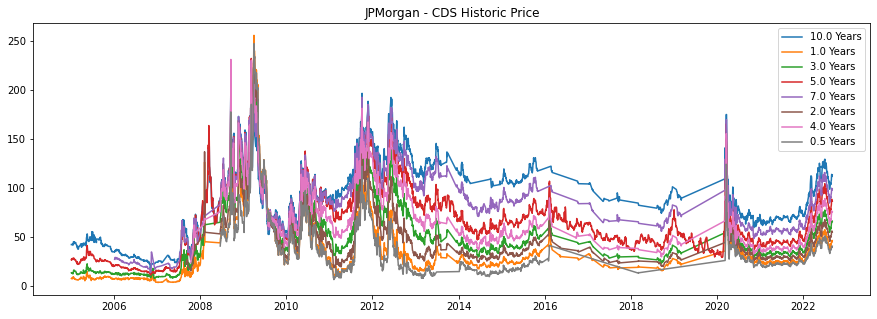

In [2]:
jp_base = plot_generalizado(fat_precos,'JPMorgan')

## Como vemos a classe de titulo mais negociada é 15Y por conta disso vamos filtrar

jp_base = jp_base[jp_base['Duracao']== '5.0']
jp_base = jp_base.reset_index().drop(columns='index')

Como podemos ver estão todos muito relacionados e quanto maior o tempo do contrato mais caro é o valor dele, entretanto existem alguns comportamentos estranhos em alguns CDS, isso se deve ao fato deles não possuirem muita liquidez, o tipo de contrato mais comum é o de 5 anos. Abaixo segue a série histórica só para contratos de 5 anos.

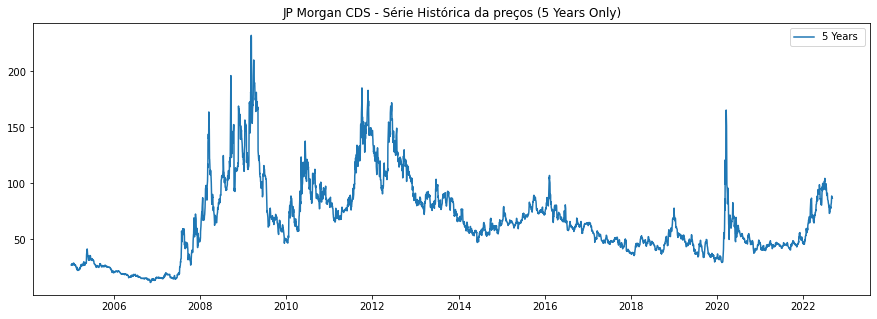

In [3]:

plt.figure(figsize=(15,5))
plt.plot(jp_base['Data'],jp_base['Preço'],label="5 Years ")
plt.title('JP Morgan CDS - Série Histórica da preços (5 Years Only)')
plt.legend()
plt.show()

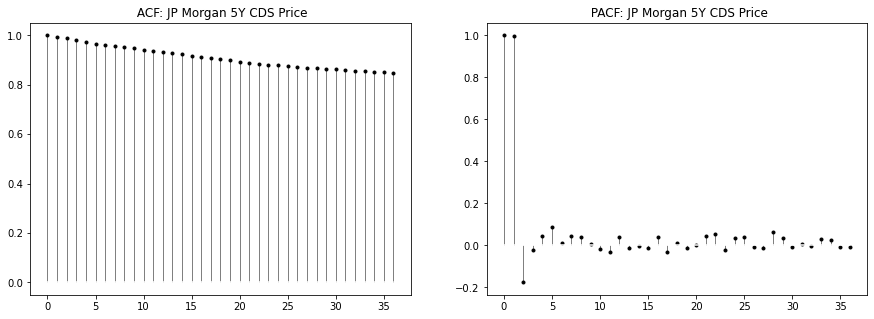

In [4]:
_ = plot_acf_pacf(jp_base['Preço'],title = ' JP Morgan 5Y CDS Price')

Embora esteja muito claro que isso seja um AR 2, vamos utilizar o Bayesian Information Criterion para escolher nosso parametros.

In [5]:
table = pd.DataFrame(np.empty((5,5)))
table.index = ['P = '+str(i) for i in table.index]
table.columns = ['Q = '+str(i) for i in table.columns]

for p in range(0,5):
    for q in range(0,5):
        order = (p,0,q)
        warnings.filterwarnings("ignore")
        model = ARIMA(jp_base['Preço'].values, order=order).fit()
        table.iloc[p,q] = model.bic

table

,Q = 0,Q = 1,Q = 2,Q = 3,Q = 4
P = 0,45659.448049,39875.296927,35646.627041,32672.197116,30707.477354
P = 1,24577.170353,24452.751576,24442.712159,24451.065492,24425.855703
P = 2,24441.379019,24448.279296,24451.123262,24431.661313,24424.109090
P = 3,24447.246591,24454.550513,24462.034709,24426.809099,24430.419697
P = 4,24446.949446,24424.061528,24460.090016,24433.281743,24439.032679


In [6]:
round(table)

,Q = 0,Q = 1,Q = 2,Q = 3,Q = 4
P = 0,45659.0,39875.0,35647.0,32672.0,30707.0
P = 1,24577.0,24453.0,24443.0,24451.0,24426.0
P = 2,24441.0,24448.0,24451.0,24432.0,24424.0
P = 3,24447.0,24455.0,24462.0,24427.0,24430.0
P = 4,24447.0,24424.0,24460.0,24433.0,24439.0


Percebemos na tabela de BIC acima que o preferivel é Q=1 e P=4, entretanto, vou usar Q=0 e P=2, ou em outras palavras, irei usar um AR(2) visto que ele possui menos da metade do número de variaveis e ainda sim a diferença entre o BIC dos modelos é irrisória.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4599
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -12203.822
Date:                Wed, 30 Nov 2022   AIC                          24415.645
Time:                        21:51:24   BIC                          24441.379
Sample:                             0   HQIC                         24424.702
                               - 4599                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         66.3214     12.482      5.313      0.000      41.857      90.785
ar.L1          1.1696      0.006    209.768      0.000       1.159       1.181
ar.L2         -0.1757      0.005    -32.160      0.0

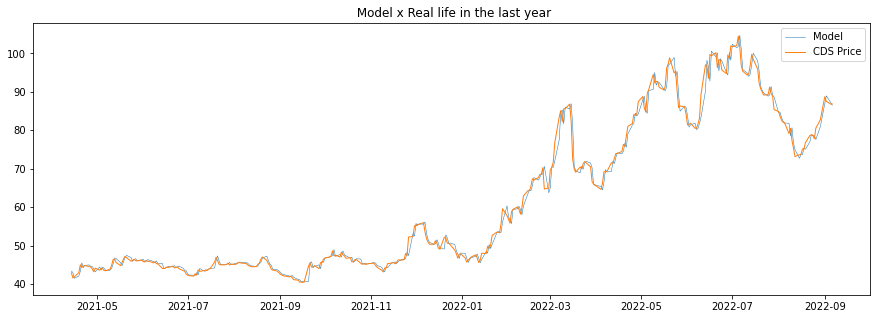

In [7]:
warnings.filterwarnings("ignore")
modelo = ARIMA(jp_base['Preço'].values, order=(2,0,0)).fit()
jp_base['Predict'] = modelo.predict()
jp_base['Erro'] = jp_base['Preço'] - jp_base['Predict']

print(modelo.summary())

plt.figure(figsize=(15,5))
plt.title(' Model x Real life in the last year')
plt.plot(jp_base['Data'][-365:], jp_base['Predict'][-365:],label = 'Model', linewidth=.5)
plt.plot(jp_base['Data'][-365:],jp_base['Preço'][-365:],label = 'CDS Price', linewidth=1)
plt.legend()
plt.show()

#### Estacionariedade da série
Vamos observar aqui se há estacionariedade na série.


In [12]:
estacionariedade_AR2(modelo) 
p_value = float(adfuller(jp_base['Preço'])[1])
print( f'P-Valor dickey-fuller {100*p_value:.2f}%  > 5%   -- É estacionário (quase)') 

phi_1 + phi_2 < 1 
   0.99 < 1

phi_1 > phi_2  
   1.17 > -0.18 

1 > abs( phi_2 )
   1 > 0.18 

É estacionário
P-Valor dickey-fuller 6.46%  > 5%   -- É estacionário (quase)


#### Estimando a distribuição de preços em Y<sub>t+s</sub> | Y<sub>t</sub>


Meu método favorito para o desenvolvimento desse case é transformar o AR em um VAM infinito escrito da forma:

$Y_t = \sum{( \begin{bmatrix}
\phi_1 & \phi_2 \\
1 & 0 
\end{bmatrix}^i
\times E_{t-i})}  $



Logo:

$Y_{t+s} = \sum{( \begin{bmatrix}
\phi_1 & \phi_2 \\
1 & 0 
\end{bmatrix}^i(_{1,1})
\times E_{t+s-i})}  $


$Y_{t+s} = \sum^{i=s-1} _{i=0}{( \begin{bmatrix}
\phi_1 & \phi_2 \\
1 & 0 
\end{bmatrix}^i(_{1,1})
\times E_{t+s-i})} + \sum_{i=s}{( \begin{bmatrix}
\phi_1 & \phi_2 \\
1 & 0 
\end{bmatrix}^{i+s}(_{1,1})
\times E_{t-i})}   $


$ \begin{bmatrix}
Y_{t+s} \\
Y_{t+s-1}
\end{bmatrix} = ( \sum^{i=s-1}_{i=0}{( \begin{bmatrix}
\phi_1 & \phi_2 \\
1 & 0 
\end{bmatrix}^i
\times \begin{bmatrix}
E_{t+s-i} \\
0
\end{bmatrix})} )+ {( \begin{bmatrix}
\phi_1 & \phi_2 \\
1 & 0 
\end{bmatrix}^{s}
\times
\begin{bmatrix}
Y_{t} \\
Y_{t-1}
\end{bmatrix}
)}   $


Ou seja, é possivel estimar qual a composição de  Y<sub>t+s</sub> | Y<sub>t</sub>


###### ***Unimos a contante $\mu$ com o termo de erro $Ɛ_t$ de forma que o termo utilizado nas equações é $E_t$ ~ $ N(\mu,\sigma^2) $, ou seja, não é um ruído branco


##### Simulação

> Parte A da equação: 
 

 $\sum_{i=0} ^ {i=t+s-1} k * E_{t+s-i}$

 $\sigma_{Y_{t+s}}^2 = \sum_{i=0} ^ {i=t+s-1} k^2 * \sigma_E^2$

 $\mathbb{E}[ {Y_{t+s}}] = \sum_{i=0} ^ {i=t+s-1} k * \mu$

> Parte B da equação: 
 
  $[A^s * Y_t ](1,1)$ (Primeiro termo desse vetor)

  $\sigma_{Y_{t+s}}^2 = 0 $

  $\mathbb{E}[ {Y_{t+s}}] = [A^s * Y_t ](1,1)$


Sempre bom relembrar que E utilizado nessas equações não é o termo de erro, e sim E = termo de erro + constante

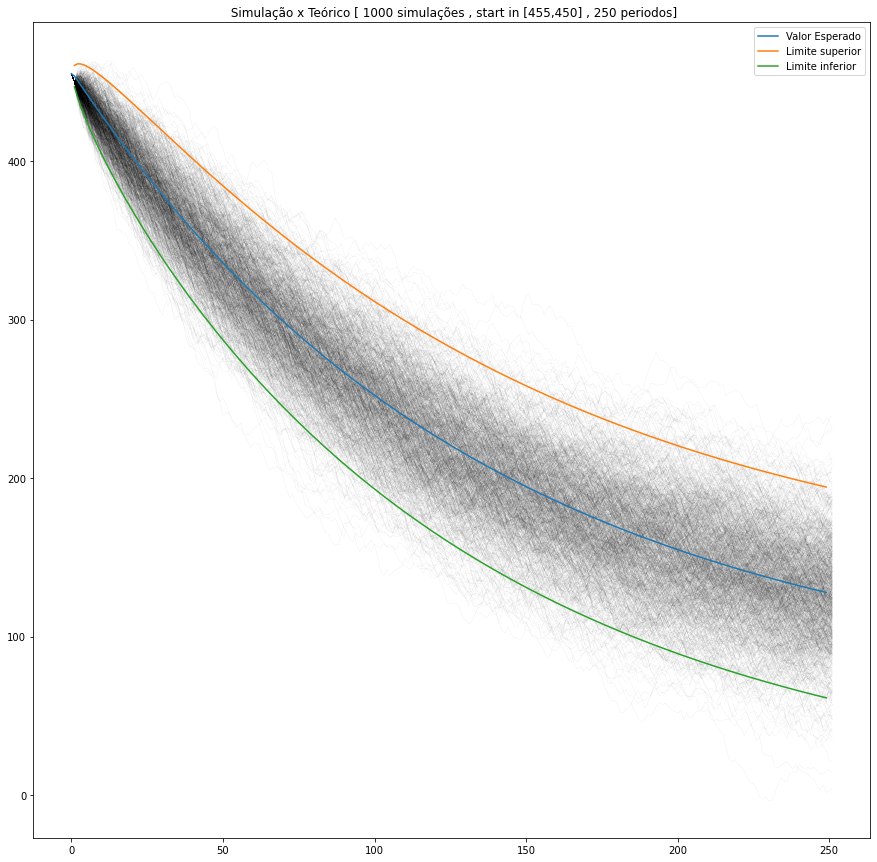

In [14]:

plt.figure(figsize=(15,15))
simulation_AR2(modelo,[455,450],250,1000,.5,.05)
future_dist_conf_AR2(modelo,[455,450],250,.95)
plt.title(' Simulação x Teórico [ 1000 simulações , start in [455,450] , 250 periodos]')
plt.legend()
plt.show()

##### Prático

Abaixo segue o plot com destaque de todas as vezes que o preço de mercado de um CDS estava acima do limite superior do intervalo de confiança.

Estamos utilizando como intervalo de confiança, o intervalo de confiança gerado por um AR(2) prevendo +15 periodos na frente, a frequencia dos dados é diária.

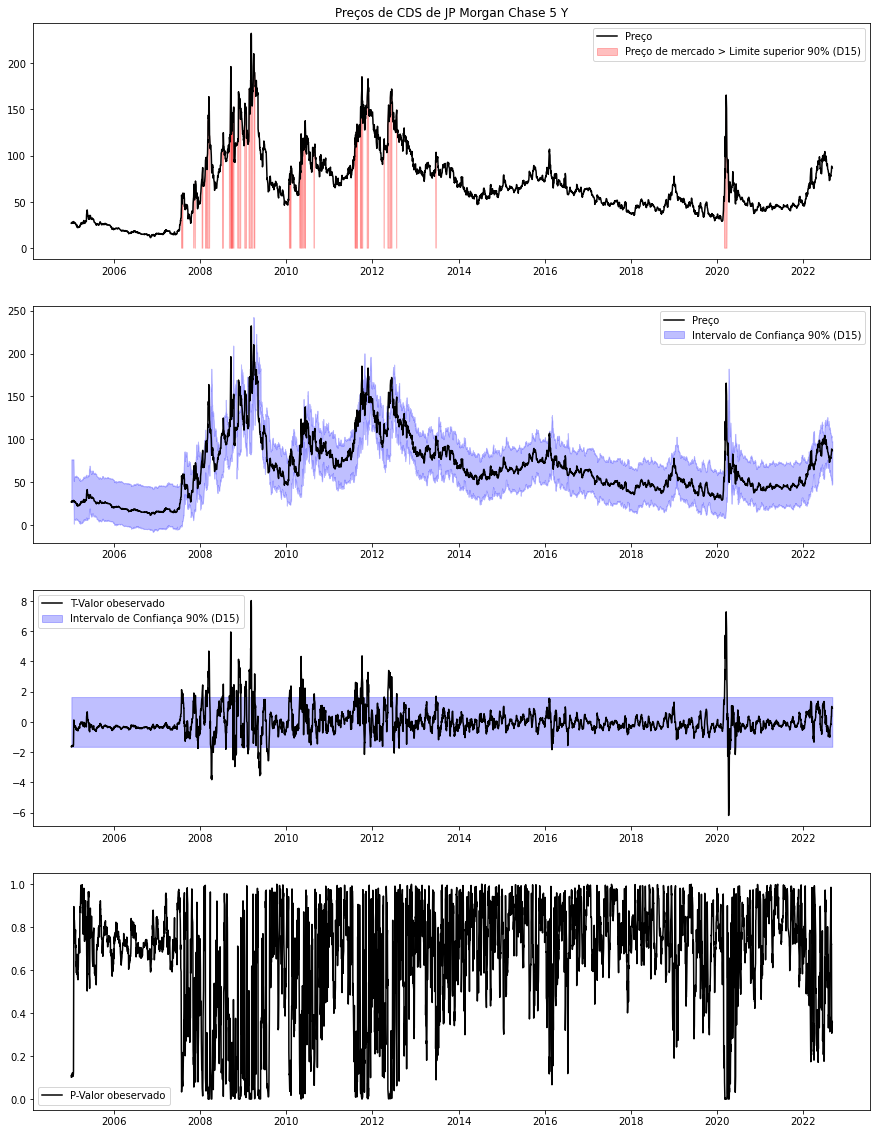

In [15]:
if True: # Criando as novas colunas
    jp_base['Valor_Teorico_d15'] = list(map(lambda x,y:  future_dist_AR2(modelo,[x,y],15)[0]
                                            ,jp_base['Preço'].shift(15).fillna(50)
                                            ,jp_base['Preço'].shift(16).fillna(50)  ))

    jp_base['Std_Teorico_d15'] =  future_dist_AR2(modelo,[50,50],15)[1]

    jp_base['T_value (D15)'] = (jp_base['Preço'] - jp_base['Valor_Teorico_d15']) / jp_base['Std_Teorico_d15']

    jp_base['P-value (D15)'] =(jp_base['T_value (D15)'].apply(lambda x: 1 - abs(norm.cdf(x) -0.5)*2 )) 

if True: # Fazendo o plot
    ci = 1.645 * future_dist_AR2(modelo,[50,50],15)[1]


    fig, ax = plt.subplots(4,1,figsize=(15, 20))

    ax[0].plot(jp_base['Data'], jp_base['Preço'], color="black", label='Preço')

    ax[0].fill_between(
        jp_base['Data'], jp_base['Preço'], 0, where=(jp_base['Preço'] > jp_base['Valor_Teorico_d15'] + ci), 
        interpolate=True, color="Red", alpha=0.25, 
        label="Preço de mercado > Limite superior 90% (D15)"
    )

    ax[0].set_title('Preços de CDS de JP Morgan Chase 5 Y')
    ax[0].legend()


    ax[1].plot(jp_base['Data'], jp_base['Preço'], color="black", label='Preço')

    ax[1].fill_between(
        jp_base['Data'], jp_base['Valor_Teorico_d15']+ci,  jp_base['Valor_Teorico_d15']-ci, 
        interpolate=True, color="Blue", alpha=0.25, 
        label="Intervalo de Confiança 90% (D15)"
    )

    ax[1].legend()


    ax[2].plot(jp_base['Data'], jp_base['T_value (D15)'], color="black", label='T-Valor obeservado')


    ax[2].fill_between(
        jp_base['Data'], 1.645, -1.645, 
        interpolate=True, color="Blue", alpha=0.25, 
        label="Intervalo de Confiança 90% (D15)"
    )
    ax[2].legend()


    ax[3].plot(jp_base['Data'], jp_base['P-value (D15)'], color="black", label='P-Valor obeservado')
    ax[3].legend()

Como podemos observar os principais desvios do preço ocorreram em periodos de crise, como por exemplo em 2008 na crise do subprime, além disso conseguimos perceber que a subida inesperada dos preços tendem a não ser aleatória, na maioria das observações realmente houverem eventos exógenos. 

#####  Risco indiciocrático

É claro que dentro dessas flutuações existem difentes fatores, os riscos do setor e os riscos indicincráticos do Banco escolhido, buscando tirar as flutuações do setor e olhar apenas para os riscos indiocincráticos, vamos criar um índice que será uma média aritmética dos preços de CDS de 5 anos dos nossos dados, como o intuito é observar a diferença de um banco contra o seu setor não faz sentido fazer uma média ponderada pelo tamanho do banco, visto que, isso pode acabar superestimando alguns grandes bancos como o próprio JP Morgan e excluindo os bancos um pouco menores.

Nesse tópicos vamos observar o comportamento do descolamento do preço do CDS de um banco com a média do mercado, o calculo é bastante simples, basta pegar o 'índice' que utilizamos e calcular a diferença dele com cada um dos bancos da base, assim teremos o 'descolamento' de cada banco com o 'índice', abaixo segue a ACF e PACF para cada banco dessa variavel de estudo.

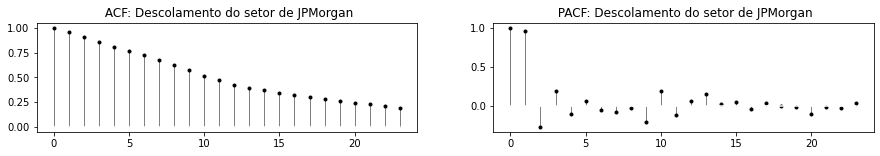

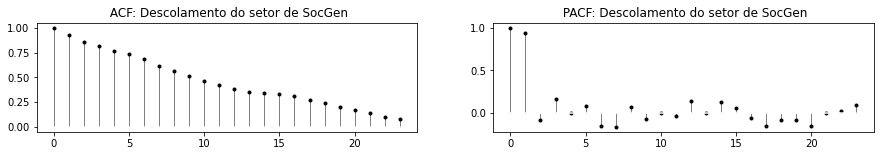

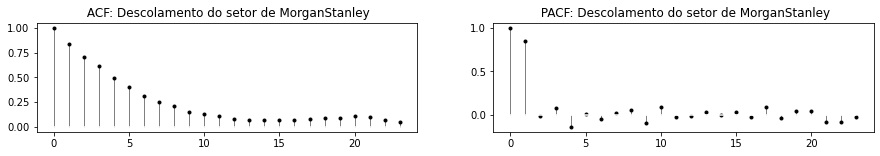

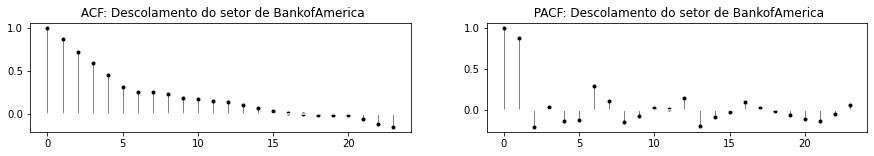

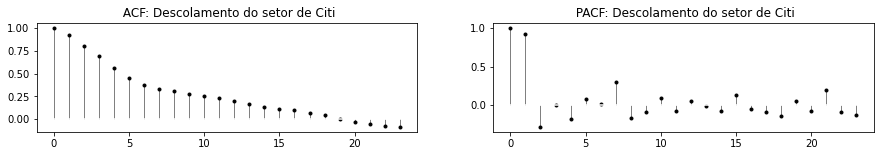

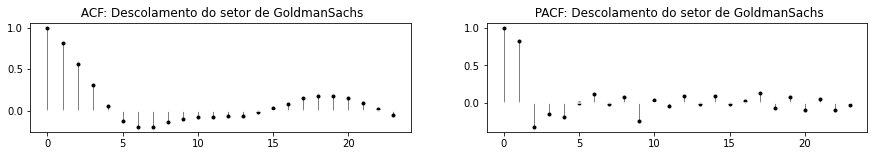

In [17]:
if True: #Construindo o indice mensal
    fat_precos_5y = fat_precos_month[fat_precos_month['Duracao']=='5.0']
    indice_cds5y = fat_precos_5y[['Data','Preço']].groupby('Data').mean()
    indice_cds5y.columns = ['Índice']
    indice_cds5y.index =[str(x)[:10] for x in indice_cds5y.index]
    indice_cds5y_dict = indice_cds5y.to_dict()['Índice']

# Fazendo o plot e o modelo
for banco in ['JPMorgan', 'SocGen', 'MorganStanley', 'BankofAmerica', 'Citi', 'GoldmanSachs']:
    banco_df = fat_precos_month[(fat_precos_month['Nome'] == banco)&(fat_precos_month['Duracao']=='5.0')]
    banco_df['Setor'] = banco_df['Data'].apply(lambda x: indice_cds5y_dict[str(x)[:10]])
    banco_df['Descolamento'] = banco_df['Preço'] - banco_df['Setor']
    plot_acf_pacf(banco_df['Descolamento'],figsize_=(15,2),title=' Descolamento do setor de '+banco)

Como é preferivel generalizar, olhando as observações da PACF, vou optar por um modelo AR(2).

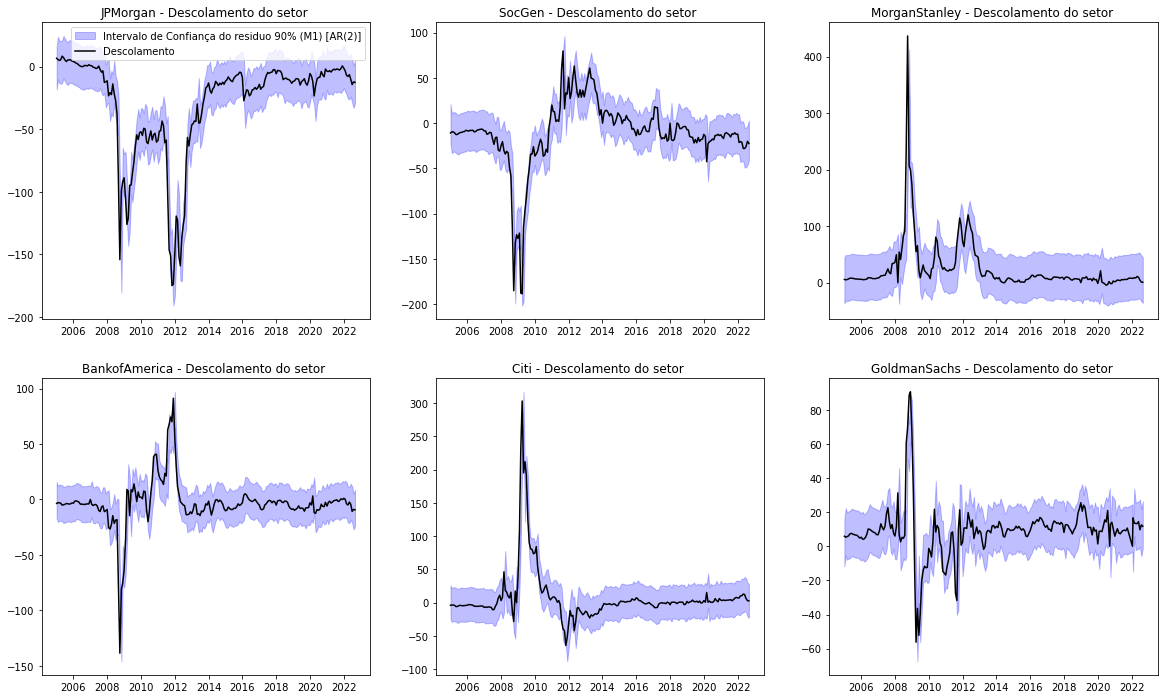

In [25]:

fig , ax =plt.subplots(2,3,figsize=(20,12))

i=0
j=0

for banco in ['JPMorgan', 'SocGen', 'MorganStanley', 'BankofAmerica', 'Citi', 'GoldmanSachs']:
    banco_df = fat_precos_month[(fat_precos_month['Nome'] == banco)&(fat_precos_month['Duracao']=='5.0')]
    banco_df['Setor'] = banco_df['Data'].apply(lambda x: indice_cds5y_dict[str(x)[:10]])
    banco_df['Descolamento'] = banco_df['Preço'] - banco_df['Setor']

    modelo2j = ARIMA(banco_df['Descolamento'].values, order=(2,0,0)).fit()
    
    banco_df['Valor_Teorico_m1'] = list(map(lambda x,y:  future_dist_AR2(modelo2j,[x,y],1)[0]
                                          ,banco_df['Descolamento'].shift(1).fillna(0)
                                          ,banco_df['Descolamento'].shift(2).fillna(0.01)  ))
    
    ci = 1.645 * future_dist_AR2(modelo2j,[0,0.01],1)[1]

    ax[j,i].fill_between(
    banco_df['Data'], banco_df['Valor_Teorico_m1']+ci,  banco_df['Valor_Teorico_m1']-ci, 
    interpolate=True, color="Blue", alpha=0.25, 
    label="Intervalo de Confiança do residuo 90% (M1) [AR(2)]")
    
    ax[j,i].plot(banco_df['Data'],banco_df['Descolamento'],color='black',label='Descolamento')
    ax[j,i].set_title(banco+ ' - Descolamento do setor ')
    if j==0==i:
        ax[j,i].legend()
    if i>=2:
        j+=1
        i=0
    else:
        i+=1
plt.show()
    

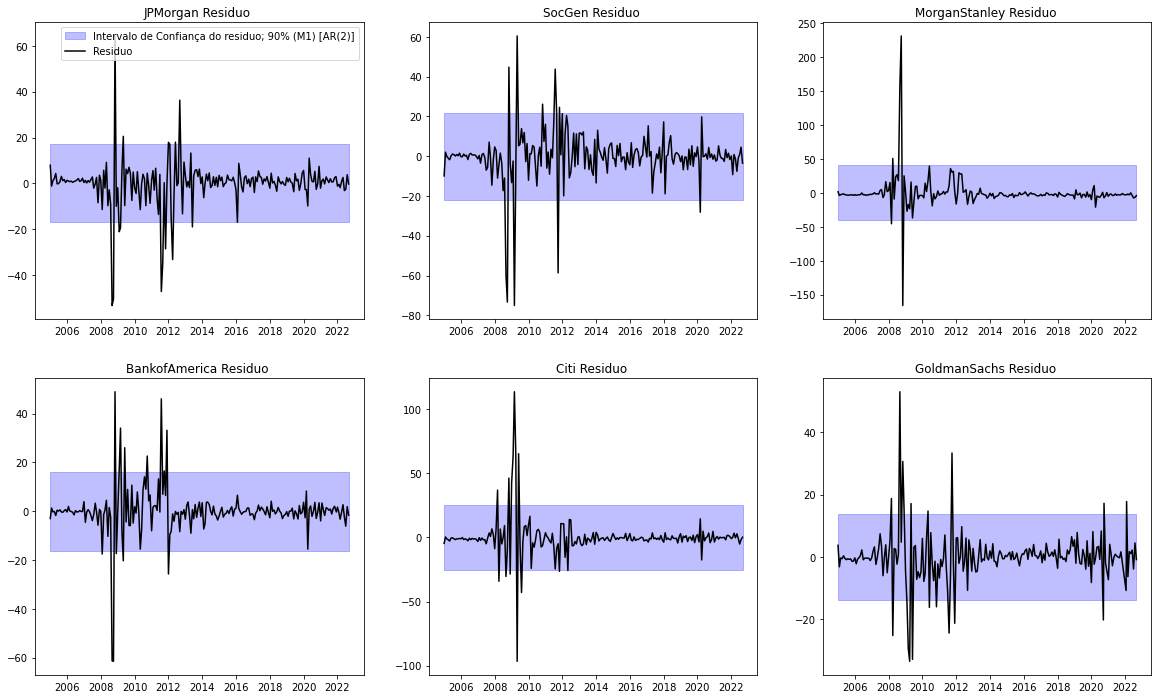

In [26]:

# Fazendo o plot e o modelo
fig , ax =plt.subplots(2,3,figsize=(20,12))

i=0
j=0

for banco in ['JPMorgan', 'SocGen', 'MorganStanley', 'BankofAmerica', 'Citi', 'GoldmanSachs']:
    banco_df = fat_precos_month[(fat_precos_month['Nome'] == banco)&(fat_precos_month['Duracao']=='5.0')]
    banco_df['Setor'] = banco_df['Data'].apply(lambda x: indice_cds5y_dict[str(x)[:10]])
    banco_df['Descolamento'] = banco_df['Preço'] - banco_df['Setor']

    modelo2j = ARIMA(banco_df['Descolamento'].values, order=(2,0,0)).fit()
    
    banco_df['Valor_Teorico_m1'] = list(map(lambda x,y:  future_dist_AR2(modelo2j,[x,y],1)[0]
                                          ,banco_df['Descolamento'].shift(1).fillna(0)
                                          ,banco_df['Descolamento'].shift(2).fillna(0.01)  ))
    
    ci = 1.645 * future_dist_AR2(modelo2j,[0,0.01],1)[1]

    banco_df['T_valor'] = (banco_df['Descolamento'] - banco_df['Valor_Teorico_m1']) 

    ax[j,i].fill_between(
    banco_df['Data'], ci,  -ci, 
    interpolate=True, color="Blue", alpha=0.25, 
    label="Intervalo de Confiança do residuo; 90% (M1) [AR(2)]")
    
    ax[j,i].plot(banco_df['Data'],banco_df['T_valor'],color='black',label='Residuo')
    ax[j,i].set_title(banco+ ' Residuo ')
    if j==0==i:
        ax[j,i].legend()
    if i>=2:
        j+=1
        i=0
    else:
        i+=1
plt.show()
    

Como podemos perceber, exceto em momentos conturbados, o residuo / ou erro do modelo segue bastante comportado abaixo vamos comparar o modelo utilizado acima com um modelo random-walk, que só replique o ultimo preço observado. (Y<sub>t+1</sub> = Y<sub>t</sub>)
Para essa comparação vamos subtrair o erro absoluto médio do modelo random-walk com o modelo AR(2) utilizado acima, caso essa váriavel fique positiva, isso significa que o modelo AR(2) está acertando mais do que simplesmente replicar o último preço.
Além disso vamos realizar um teste de comparação de média entre o erro absoluto do modelo random-walk e AR(2), com hipótese nula sendo a que  ambos os modelos erram iguais e a hipótese alternativa é que a média de erro dos modelos é diferente.

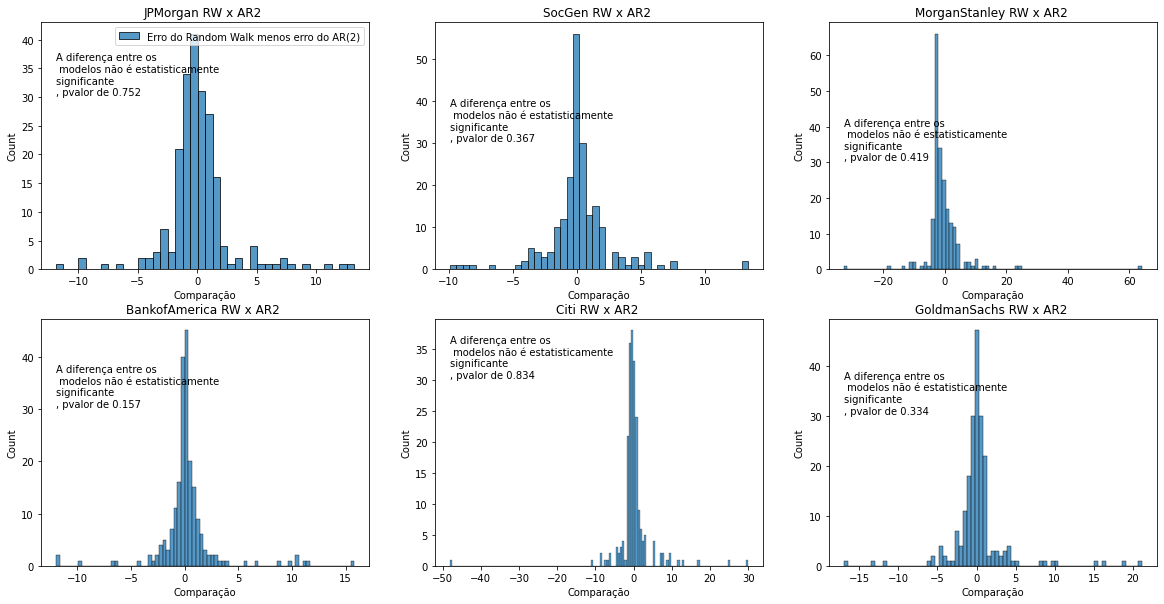

In [27]:

# Fazendo o plot e o modelo
fig , ax =plt.subplots(2,3,figsize=(20,10))

i=0
j=0

for banco in ['JPMorgan', 'SocGen', 'MorganStanley', 'BankofAmerica', 'Citi', 'GoldmanSachs']:
    banco_df = fat_precos_month[(fat_precos_month['Nome'] == banco)&(fat_precos_month['Duracao']=='5.0')]
    banco_df['Setor'] = banco_df['Data'].apply(lambda x: indice_cds5y_dict[str(x)[:10]])
    banco_df['Descolamento'] = banco_df['Preço'] - banco_df['Setor']

    modelo2j = ARIMA(banco_df['Descolamento'].values, order=(2,0,0)).fit()
    
    banco_df['Valor_Teorico_m1'] = list(map(lambda x,y:  future_dist_AR2(modelo2j,[x,y],1)[0]
                                          ,banco_df['Descolamento'].shift(1).fillna(0)
                                          ,banco_df['Descolamento'].shift(2).fillna(0.01)  ))

    banco_df['Squared_Error(R2)'] =abs(banco_df['Descolamento'] - banco_df['Valor_Teorico_m1']) 
    banco_df['Squared_Error(RW)'] =abs(banco_df['Descolamento'] - banco_df['Descolamento'].shift(1).fillna(method='bfill'))
    banco_df['Comparação'] = banco_df['Squared_Error(RW)'] - banco_df['Squared_Error(R2)']

    #ax[j,i].plot(banco_df['Data'],banco_df['Comparação'],color='black',label='Comparação')

    # Teste de comparação de média, t_obs da diferença
    t_obs = (banco_df['Comparação']).mean() / banco_df['Comparação'].std() *  (len(banco_df['Comparação'])**.5) 

    #pvalor da hipótese das médias serem iguais 
    p_valor = 1-abs(norm.cdf(t_obs)-0.5)*2

    if p_valor < 0.1 and abs(banco_df['Squared_Error(RW)'].mean()) < abs(banco_df['Squared_Error(R2)'].mean()):
        message= f'RW acertou mais do que R2, pvalor de {round(p_valor,3)}'
    elif p_valor <0.1:
        message= f'R2 acertou mais do que RW, pvalor de {round(p_valor,3)}'
    else:
        message = f'A diferença entre os \n modelos não é estatisticamente\nsignificante \n, pvalor de {round(p_valor,3)}'


    sns.histplot(banco_df['Comparação'],ax=ax[j,i],label='Erro do Random Walk menos erro do AR(2)')
    x_position_text = min(banco_df['Comparação'])
    ax[j,i].text(x_position_text, 30, message, horizontalalignment='left', verticalalignment='bottom')

    ax[j,i].set_title(banco+ ' RW x AR2 ')

    if j==0==i:
        ax[j,i].legend()
    if i>=2:
        j+=1
        i=0
    else:
        i+=1
plt.show()
    

Como podemos perceber parece que aparentemente o modelo não é muito acertivo, mas pelo menos, pelo histórico anterior ele consegue servir como parametro para identificar movimentos exóticos do mercado, visto que ele oferece um intervalo de confiança para o ruído branco, caso esse erro não esteja dentro do intervalo de confiança do ruído branco, bastante provavel que esteja ocorrendo algum evento anormal.

#### Modelo VAR como explicativo para os preços de CDS

Vamos avançar um pouco e partir para um modelo mais elaborado, vamos utilizar um modelo VAR com as seguintes variaveis: Price to Book, P/E ratio, Volatility, Financial Lavarage, Net Debt to Sharholder Equity para explicar o preço do CDS 5Y de cada banco. 

A seguir na visualizações teremos:
 > O pairplot dos nossos dados, uma matriz de scatterplots com os histogramas na diagonal;
 
 > Os parametros do modelo VAR otimizado por AIC, junto de seus p-valores;
 
 > Uma visualização "Modelo x Random-Walk", cada ponto desse gráfico, mostra o ganho por utilizar esse modelo para previsão, em vez de assumir raiz unitária e repetir a última observação em uma previsão.
    >> Na parte superior do gráfico há o p-valor de um teste-t de comparação de médias, para as médias absolutas de cada erro
    

-------------------- 
 JPMorgan : Pairplot 
 --------------------


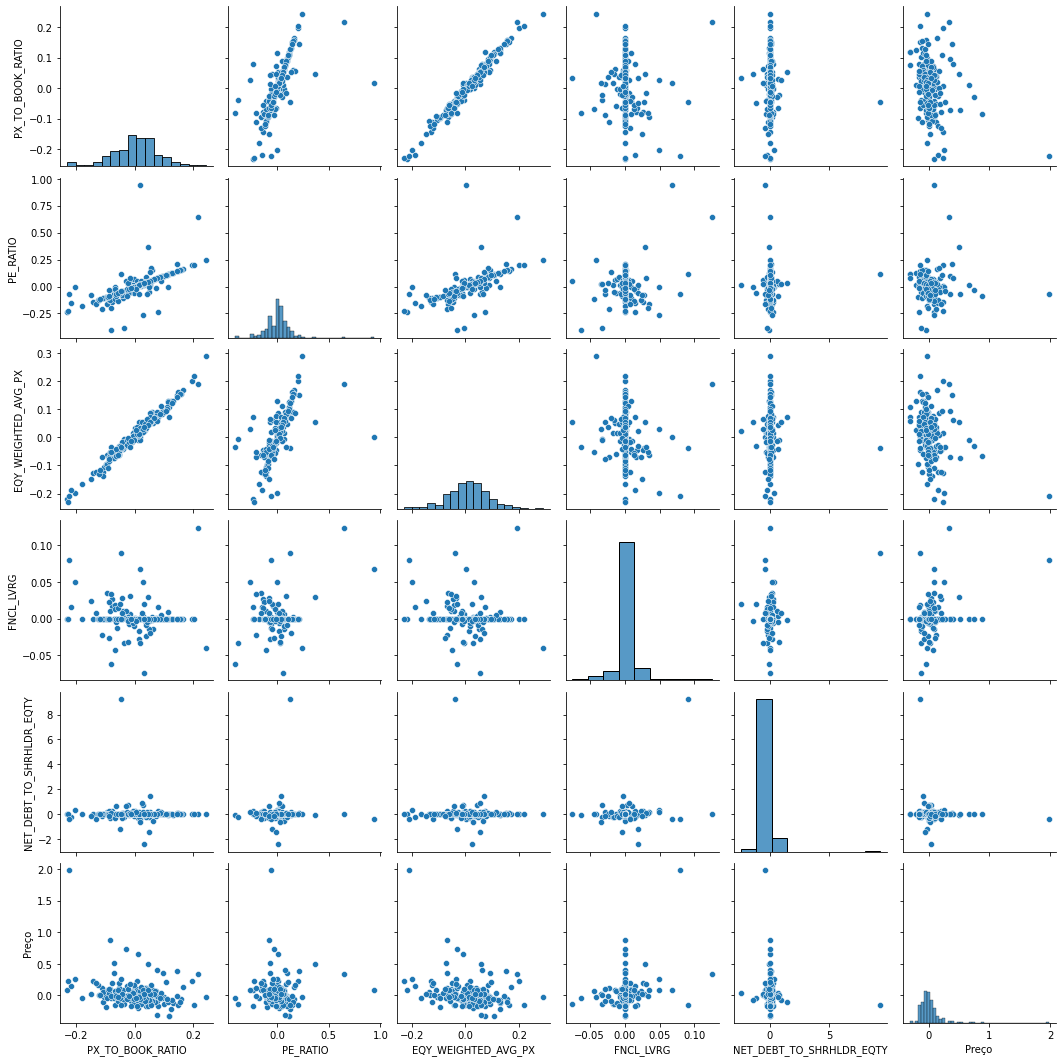

-------------------- 
 JPMorgan : Summary (VAR) 
 --------------------


,Params,P-Valor
const,0.052964,0.023
L1.PX_TO_BOOK_RATIO,1.403502,0.313
L1.PE_RATIO,-0.211340,0.241
L1.EQY_WEIGHTED_AVG_PX,-2.097563,0.120
L1.FNCL_LVRG,0.172722,0.865
L1.NET_DEBT_TO_SHRHLDR_EQTY,-0.004602,0.831
L1.Preço,-0.137356,0.092
L2.PX_TO_BOOK_RATIO,0.413982,0.779
L2.PE_RATIO,-0.340024,0.057
L2.EQY_WEIGHTED_AVG_PX,-0.357589,0.806




-------------------- 
 JPMorgan : Erro modelo 
 --------------------


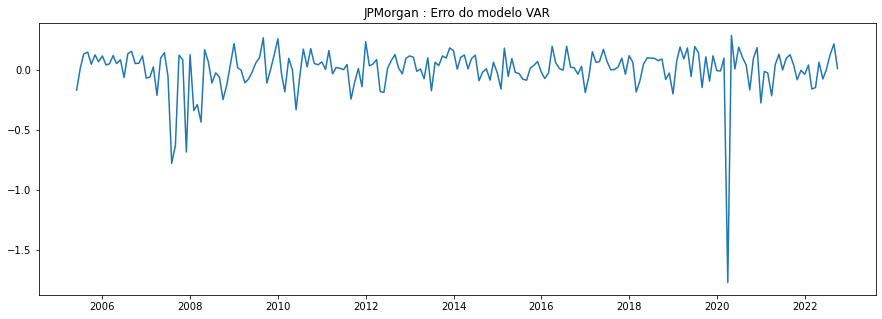

-------------------- 
 JPMorgan : Erro modelo VAR x Random-Walk 
 --------------------
P-valor da comparação de média: 0.026900362109320102


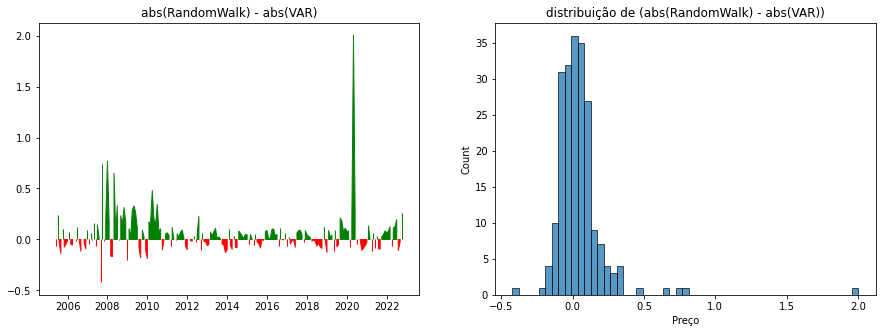

-------------------- 
 JPMorgan : IRF 
 --------------------


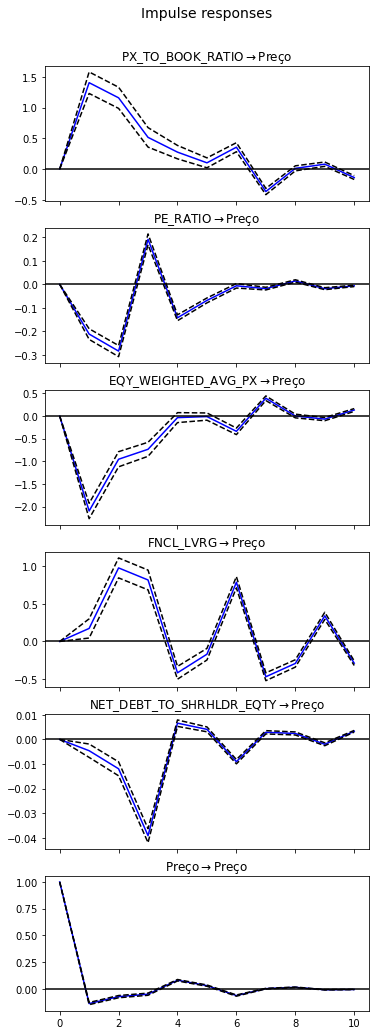

Obs: nivel de significancia da função resposta impulso foi aumentado pra diminuir o intervalo de confiança e reduzir a poluição do gráfico


In [30]:
banco_escolhido = 'JPMorgan'
if True:
    #Busca modelo e dataframe
    modelo1 , df_modelo = aplica_VAR(banco_escolhido)
    diferienciacao = df_modelo.pct_change().dropna()
    df_modelo = diferienciacao
    modelo = VAR(diferienciacao)
    modelo = modelo.fit(maxlags=3, ic='aic')

    #Faz o plot
    print( '-'*20 , f'\n {banco_escolhido} : Pairplot \n','-'*20 )
    sns.pairplot(df_modelo,markers={'color':'gray'})
    plt.show()

    #Summary Improvisado
    print( '-'*20 , f'\n {banco_escolhido} : Summary (VAR) \n','-'*20 )
    tabela = pd.DataFrame()
    tabela['Params'] = modelo.params['Preço']
    tabela['P-Valor'] = round(modelo.pvalues['Preço'],3)
    display(tabela)
    print('\n')

    # Erro ao longo do tempo
    print( '-'*20 , f'\n {banco_escolhido} : Erro modelo \n','-'*20 )
    plt.figure(figsize=(15,5))
    plt.title(banco_escolhido+' : Erro do modelo VAR')
    plt.plot(modelo.fittedvalues['Preço'] - df_modelo['Preço'])
    plt.show()

    #Comparando com um random-walk simples
    print( '-'*20 , f'\n {banco_escolhido} : Erro modelo VAR x Random-Walk \n','-'*20 )
    fig , ax = plt.subplots(1,2,figsize=(15,5))
    erro_rw = abs(df_modelo['Preço'] - df_modelo['Preço'].shift(1).fillna(method='bfill')) 
    erro_var = abs(modelo.fittedvalues['Preço'] - df_modelo['Preço'])
    ax[0].plot(erro_rw-erro_var,color='gray',lw=0.1)
    ax[0].fill_between(erro_var.index,0,(erro_rw-erro_var),(erro_rw-erro_var)>0,color='Green')
    ax[0].fill_between(erro_var.index,0,(erro_rw-erro_var),(erro_rw-erro_var)<0,color='Red')
    
    sns.histplot((erro_rw-erro_var),ax=ax[1])
    t_obs , p_valor = ttest_ind(erro_rw,erro_var.fillna(method='bfill'))

    print('P-valor da comparação de média:',p_valor)
    ax[0].set_title('abs(RandomWalk) - abs(VAR)')
    ax[1].set_title('distribuição de (abs(RandomWalk) - abs(VAR))')

    plt.show()


    #Funções resposta impulso (modelo sem diferenciação)
    print( '-'*20 , f'\n {banco_escolhido} : IRF \n','-'*20 )
    irf = modelo.irf(10)
    k = irf.plot(response='Preço', figsize=(5,15),signif=0.90,plot_params={'color':'gray'})
    plt.show()
    print('Obs: nivel de significancia da função resposta impulso foi aumentado pra diminuir o intervalo de confiança e reduzir a poluição do gráfico')

-------------------- 
 MorganStanley : Pairplot 
 --------------------


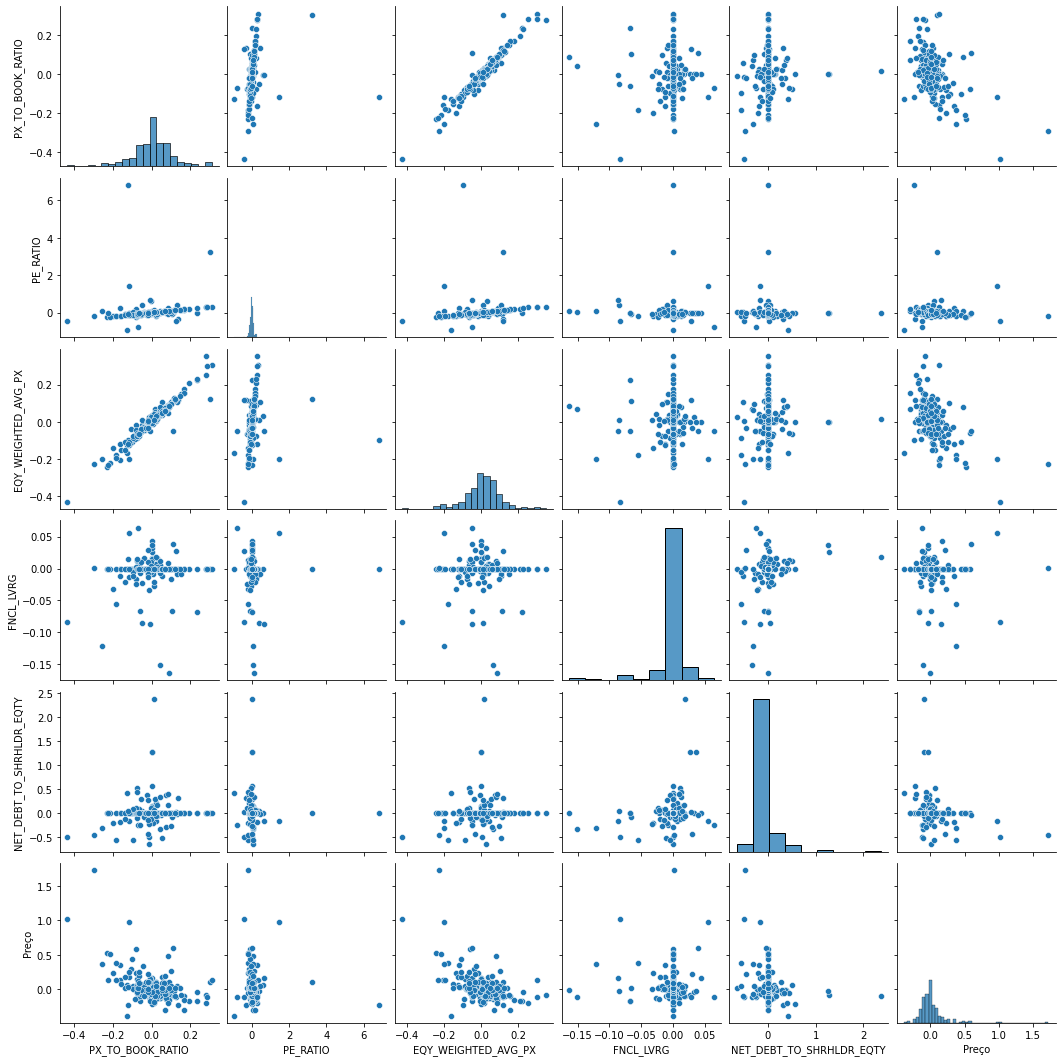

-------------------- 
 MorganStanley : Summary (VAR) 
 --------------------


,Params,P-Valor
const,0.029807,0.076
L1.PX_TO_BOOK_RATIO,-0.581793,0.332
L1.PE_RATIO,0.049246,0.074
L1.EQY_WEIGHTED_AVG_PX,-0.071659,0.909
L1.FNCL_LVRG,0.354301,0.590
L1.NET_DEBT_TO_SHRHLDR_EQTY,-0.010240,0.900
L1.Preço,-0.021940,0.798
L2.PX_TO_BOOK_RATIO,-0.559296,0.362
L2.PE_RATIO,0.023652,0.406
L2.EQY_WEIGHTED_AVG_PX,0.744121,0.246




-------------------- 
 MorganStanley : Erro modelo 
 --------------------


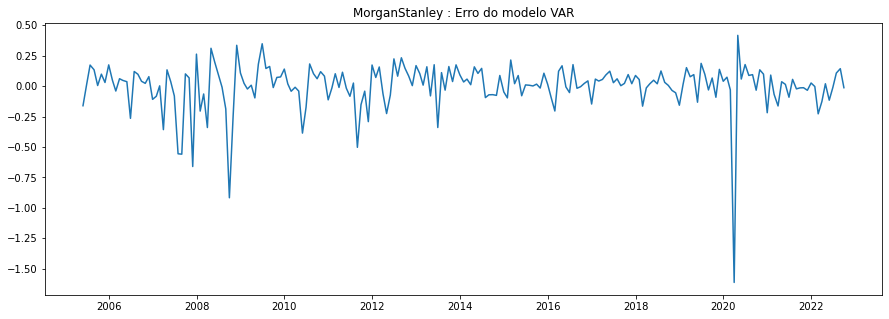

-------------------- 
 MorganStanley : Erro modelo VAR x Random-Walk 
 --------------------
P-valor da comparação de média: 0.10299305323986357


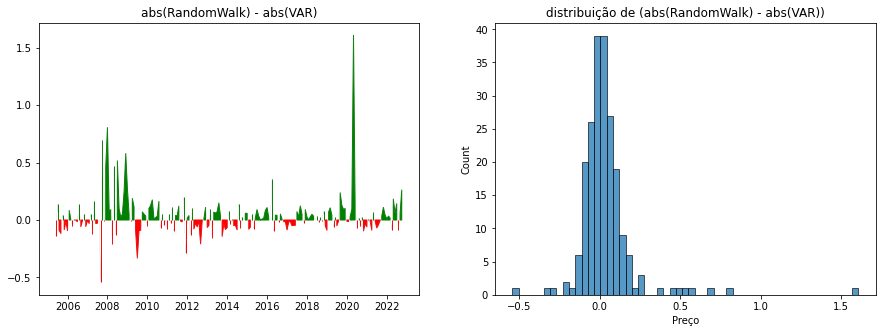

-------------------- 
 MorganStanley : IRF 
 --------------------


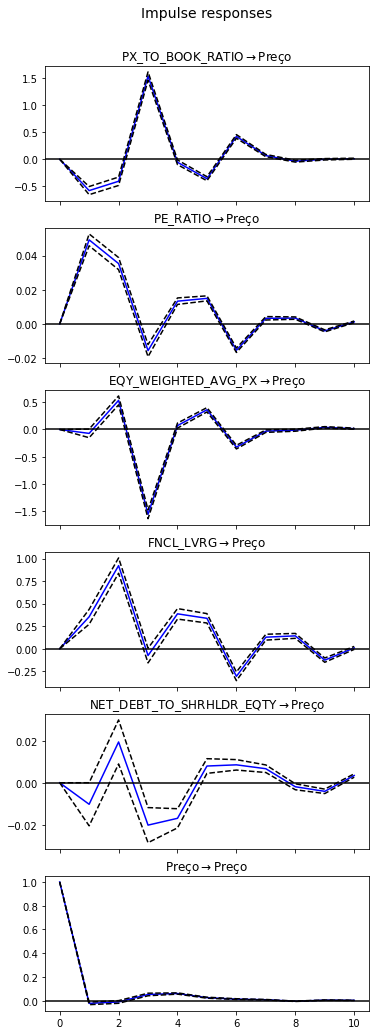

Obs: nivel de significancia da função resposta impulso foi aumentado pra diminuir o intervalo de confiança e reduzir a poluição do gráfico


In [15]:
banco_escolhido = 'MorganStanley'
if True:
    #Busca modelo e dataframe
    modelo1 , df_modelo = aplica_VAR(banco_escolhido)
    diferienciacao = df_modelo.pct_change().dropna()
    df_modelo = diferienciacao
    modelo = VAR(diferienciacao)
    modelo = modelo.fit(maxlags=3, ic='aic')

    #Faz o plot
    print( '-'*20 , f'\n {banco_escolhido} : Pairplot \n','-'*20 )
    sns.pairplot(df_modelo)
    plt.show()

    #Summary Improvisado
    print( '-'*20 , f'\n {banco_escolhido} : Summary (VAR) \n','-'*20 )
    tabela = pd.DataFrame()
    tabela['Params'] = modelo.params['Preço']
    tabela['P-Valor'] = round(modelo.pvalues['Preço'],3)
    display(tabela)
    print('\n')

    # Erro ao longo do tempo
    print( '-'*20 , f'\n {banco_escolhido} : Erro modelo \n','-'*20 )
    plt.figure(figsize=(15,5))
    plt.title(banco_escolhido+' : Erro do modelo VAR')
    plt.plot(modelo.fittedvalues['Preço'] - df_modelo['Preço'])
    plt.show()

    #Comparando com um random-walk simples
    print( '-'*20 , f'\n {banco_escolhido} : Erro modelo VAR x Random-Walk \n','-'*20 )
    fig , ax = plt.subplots(1,2,figsize=(15,5))
    erro_rw = abs(df_modelo['Preço'] - df_modelo['Preço'].shift(1).fillna(method='bfill')) 
    erro_var = abs(modelo.fittedvalues['Preço'] - df_modelo['Preço'])
    ax[0].plot(erro_rw-erro_var,color='gray',lw=0.1)
    ax[0].fill_between(erro_var.index,0,(erro_rw-erro_var),(erro_rw-erro_var)>0,color='Green')
    ax[0].fill_between(erro_var.index,0,(erro_rw-erro_var),(erro_rw-erro_var)<0,color='Red')
    
    sns.histplot((erro_rw-erro_var),ax=ax[1])
    t_obs , p_valor = ttest_ind(erro_rw,erro_var.fillna(method='bfill'))

    print('P-valor da comparação de média:',p_valor)
    ax[0].set_title('abs(RandomWalk) - abs(VAR)')
    ax[1].set_title('distribuição de (abs(RandomWalk) - abs(VAR))')

    plt.show()


    #Funções resposta impulso (modelo sem diferenciação)
    print( '-'*20 , f'\n {banco_escolhido} : IRF \n','-'*20 )
    irf = modelo.irf(10)
    k = irf.plot(response='Preço', figsize=(5,15),signif=0.90,plot_params={'color':'gray'})
    plt.show()
    print('Obs: nivel de significancia da função resposta impulso foi aumentado pra diminuir o intervalo de confiança e reduzir a poluição do gráfico')

-------------------- 
 GoldmanSachs : Pairplot 
 --------------------


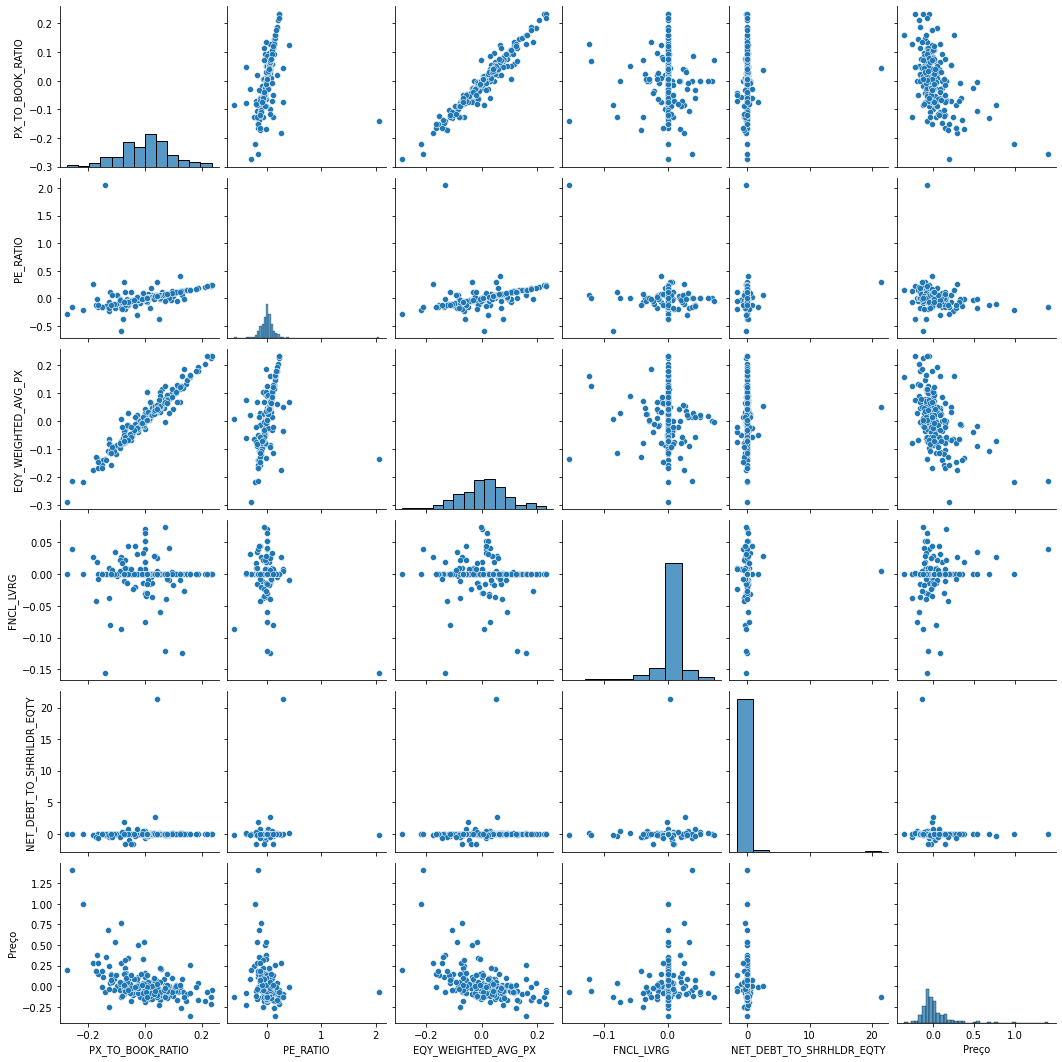

-------------------- 
 GoldmanSachs : Summary (VAR) 
 --------------------


,Params,P-Valor
const,0.017490,0.312
L1.PX_TO_BOOK_RATIO,0.286521,0.647
L1.PE_RATIO,-0.049891,0.582
L1.EQY_WEIGHTED_AVG_PX,-1.110654,0.075
L1.FNCL_LVRG,-1.038835,0.077
L1.NET_DEBT_TO_SHRHLDR_EQTY,0.000380,0.965
L1.Preço,-0.049683,0.557
L2.PX_TO_BOOK_RATIO,-1.160582,0.077
L2.PE_RATIO,0.041077,0.640
L2.EQY_WEIGHTED_AVG_PX,1.219208,0.066




-------------------- 
 GoldmanSachs : Erro modelo 
 --------------------


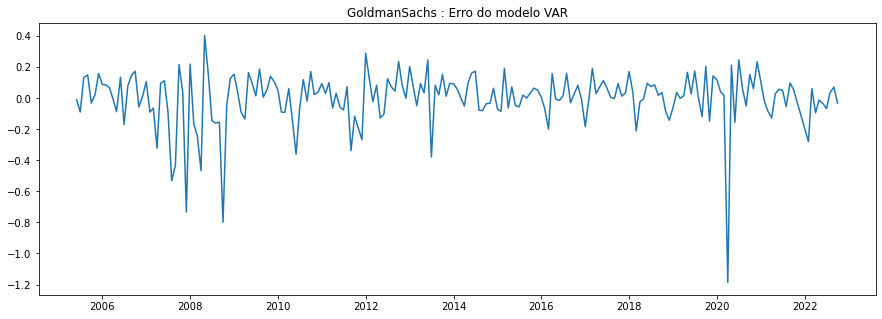

-------------------- 
 GoldmanSachs : Erro modelo VAR x Random-Walk 
 --------------------
P-valor da comparação de média: 0.084233643018006


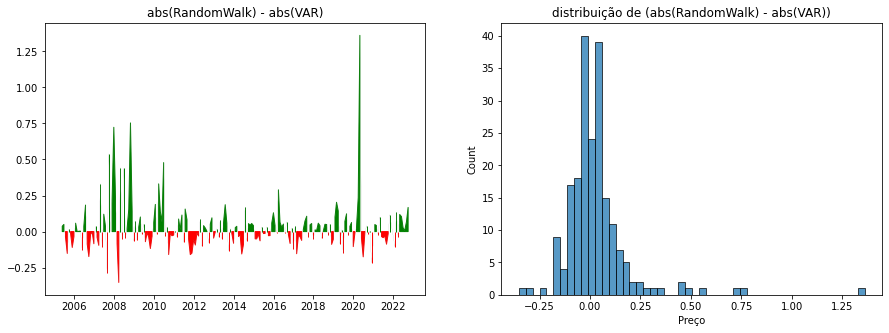

-------------------- 
 GoldmanSachs : IRF 
 --------------------


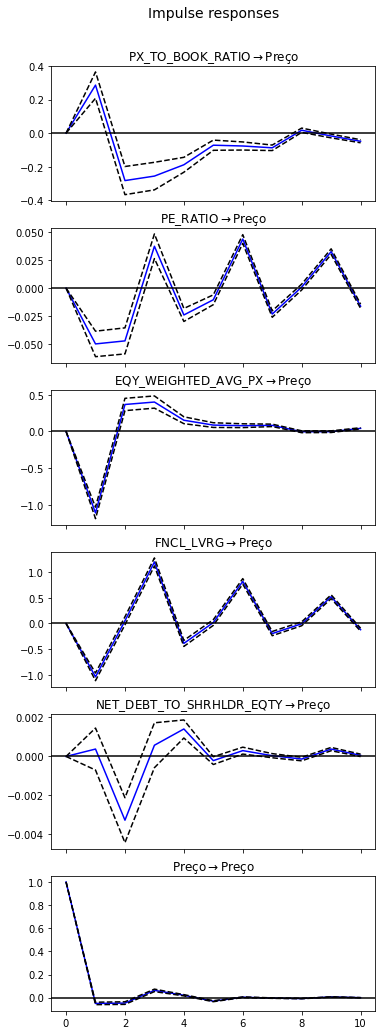

Obs: nivel de significancia da função resposta impulso foi aumentado pra diminuir o intervalo de confiança e reduzir a poluição do gráfico


In [16]:
banco_escolhido = 'GoldmanSachs'
if True:
    #Busca modelo e dataframe
    modelo1 , df_modelo = aplica_VAR(banco_escolhido)
    diferienciacao = df_modelo.pct_change().dropna()
    df_modelo = diferienciacao
    modelo = VAR(diferienciacao)
    modelo = modelo.fit(maxlags=3, ic='aic')

    #Faz o plot
    print( '-'*20 , f'\n {banco_escolhido} : Pairplot \n','-'*20 )
    sns.pairplot(df_modelo)
    plt.show()

    #Summary Improvisado
    print( '-'*20 , f'\n {banco_escolhido} : Summary (VAR) \n','-'*20 )
    tabela = pd.DataFrame()
    tabela['Params'] = modelo.params['Preço']
    tabela['P-Valor'] = round(modelo.pvalues['Preço'],3)
    display(tabela)
    print('\n')

    # Erro ao longo do tempo
    print( '-'*20 , f'\n {banco_escolhido} : Erro modelo \n','-'*20 )
    plt.figure(figsize=(15,5))
    plt.title(banco_escolhido+' : Erro do modelo VAR')
    plt.plot(modelo.fittedvalues['Preço'] - df_modelo['Preço'])
    plt.show()

    #Comparando com um random-walk simples
    print( '-'*20 , f'\n {banco_escolhido} : Erro modelo VAR x Random-Walk \n','-'*20 )
    fig , ax = plt.subplots(1,2,figsize=(15,5))
    erro_rw = abs(df_modelo['Preço'] - df_modelo['Preço'].shift(1).fillna(method='bfill')) 
    erro_var = abs(modelo.fittedvalues['Preço'] - df_modelo['Preço'])
    ax[0].plot(erro_rw-erro_var,color='gray',lw=0.1)
    ax[0].fill_between(erro_var.index,0,(erro_rw-erro_var),(erro_rw-erro_var)>0,color='Green')
    ax[0].fill_between(erro_var.index,0,(erro_rw-erro_var),(erro_rw-erro_var)<0,color='Red')
    
    sns.histplot((erro_rw-erro_var),ax=ax[1])
    t_obs , p_valor = ttest_ind(erro_rw,erro_var.fillna(method='bfill'))

    print('P-valor da comparação de média:',p_valor)
    ax[0].set_title('abs(RandomWalk) - abs(VAR)')
    ax[1].set_title('distribuição de (abs(RandomWalk) - abs(VAR))')

    plt.show()


    #Funções resposta impulso 
    print( '-'*20 , f'\n {banco_escolhido} : IRF \n','-'*20 )
    irf = modelo.irf(10)
    k = irf.plot(response='Preço', figsize=(5,15),signif=0.90,plot_params={'color':'gray'})
    plt.show()
    print('Obs: nivel de significancia da função resposta impulso foi aumentado pra diminuir o intervalo de confiança e reduzir a poluição do gráfico')

Como podemos observar esse modelo trás um resultado bem mais satisfatorio do que o moelo anterior, e quando confrontamos ele contra o modelo Random-Walk o P-valor do teste de comparação de média é bem mais satisfatório visto que em alguns casos o p-valor fica menor até mesmo do que 0.1.

#### Adicionando a variavel "spread" nosso modelo

Dado que as unicas coisas que diferenciam um CDS para outro é a duração do contrato e o risco que está sendo protegido, uma hipótese que pode ser levantada é, em momentos de crise de confiança na liquidez de um banco, o preço dos CDS deveriam se aproximar já que todos eles cobrem esse periodo conturbado.
Caso essa dinâmica não ocorresse, individuos conseguiriam comprar CDS 1Y e vender CDS 5Y de modo que estariam assegurados da crise sem ter necessariamente saido com saldo negativo, ou seja, seria possivel realizar arbitragem.

Abaixo vamos fazer uma matriz de correlação dentre os possiveis spreads com pelo menos 4 anos de diff e o preço de um CDS 5Y, uma matriz de correlação da diferenciação e isto para cada banco.

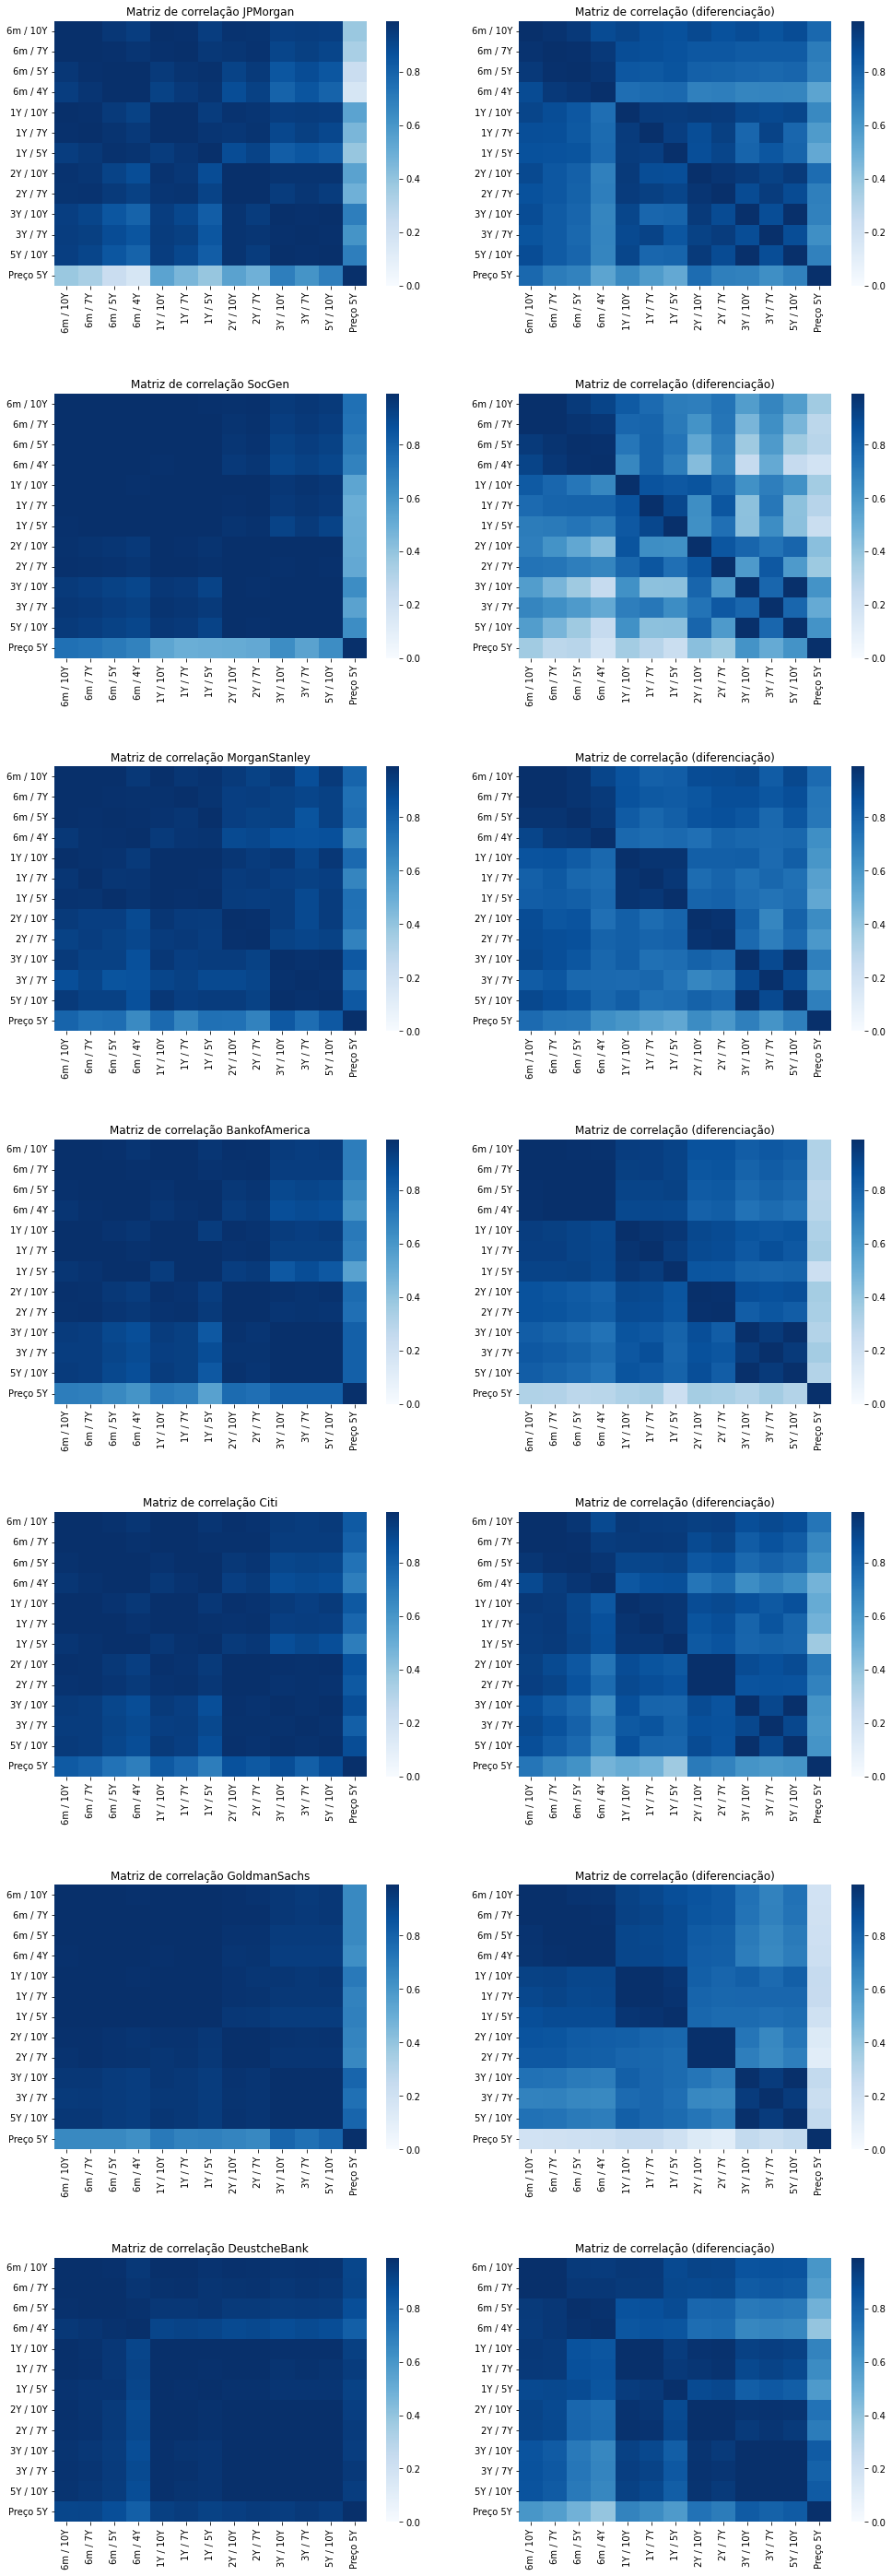

In [17]:
i=-1
fig, ax = plt.subplots(7,2, figsize=(15,40)) 

for banco_escolhido in ['JPMorgan', 'SocGen', 'MorganStanley', 'BankofAmerica', 'Citi', 'GoldmanSachs', 'DeustcheBank']:
    i+=1
    df_banco = fat_precos_month[fat_precos_month['Nome']==banco_escolhido][['Year','Month','Duracao','Preço']]
    df_banco = pd.pivot(df_banco.set_index(['Year','Month']),columns='Duracao').reset_index().reset_index().drop(columns='index')
    df_banco.columns = [' '.join(col) for col in df_banco.columns]
    df_spread = df_banco[['Year ','Month ']]

    df_spread['6m / 10Y'] = df_banco['Preço 0.5'] / df_banco['Preço 10.0']
    df_spread['6m / 7Y']  = df_banco['Preço 0.5'] / df_banco['Preço 7.0']
    df_spread['6m / 5Y']  = df_banco['Preço 0.5'] / df_banco['Preço 5.0']
    df_spread['6m / 4Y']  = df_banco['Preço 0.5'] / df_banco['Preço 4.0']

    df_spread['1Y / 10Y'] = df_banco['Preço 1.0'] / df_banco['Preço 10.0']
    df_spread['1Y / 7Y']  = df_banco['Preço 1.0'] / df_banco['Preço 7.0']
    df_spread['1Y / 5Y']  = df_banco['Preço 1.0'] / df_banco['Preço 5.0']

    df_spread['2Y / 10Y'] = df_banco['Preço 2.0'] / df_banco['Preço 10.0']
    df_spread['2Y / 7Y']  = df_banco['Preço 2.0'] / df_banco['Preço 7.0']

    df_spread['3Y / 10Y'] = df_banco['Preço 3.0'] / df_banco['Preço 10.0']
    df_spread['3Y / 7Y']  = df_banco['Preço 3.0'] / df_banco['Preço 7.0']

    df_spread['5Y / 10Y'] = df_banco['Preço 3.0'] / df_banco['Preço 10.0']

    df_spread['Preço 5Y'] = df_banco['Preço 5.0']


    correlo_map = df_spread.drop(columns=['Year ','Month ']).corr()
    correlo_map2 = df_spread.pct_change().drop(columns=['Year ','Month ']).corr()

    sns.heatmap(correlo_map,cmap='Blues',vmin=0,vmax=0.99,ax=ax[i,0])
    sns.heatmap(correlo_map2,cmap='Blues',vmin=0,vmax=0.99,ax=ax[i,1])

    ax[i,0].set_title('Matriz de correlação '+banco_escolhido)
    ax[i,1].set_title('Matriz de correlação (diferenciação)')

fig.tight_layout(pad=5.0)
 
plt.show()


Como podemos perceber, realmente quando o preço de CDS de 5Y aumenta a razão entre CDS curto e CDS longo também aumenta, vamos tentar colocar isso no nosso modelo, entretanto para não ficar com muitas variaveis vamos escolher o spread que possuimos mais dados. 

Spread escolhido:  1Y / 5Y
-------------------- 
 JPMorgan : Summary (VAR) 
 --------------------


,Params,P-Valor
const,0.053461,0.022
L1.PX_TO_BOOK_RATIO,1.507041,0.281
L1.PE_RATIO,-0.217154,0.231
L1.EQY_WEIGHTED_AVG_PX,-2.166756,0.110
L1.FNCL_LVRG,0.068799,0.946
L1.NET_DEBT_TO_SHRHLDR_EQTY,-0.005457,0.801
L1.Preço,-0.170638,0.062
L1.1Y / 5Y,0.104798,0.365
L2.PX_TO_BOOK_RATIO,0.302739,0.838
L2.PE_RATIO,-0.342444,0.057




-------------------- 
 JPMorgan : Erro modelo VAR x Random-Walk 
 --------------------
P-valor da comparação de média: 0.9724224713773701


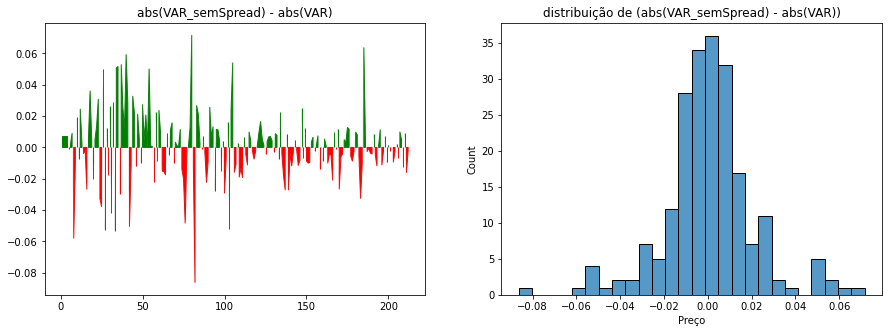

,S_spread,C_spread
aic,-32.242,-36.259
bic,-30.419,-33.796
hqic,-31.505,-35.263
fpe,0.000,0.000


In [26]:
banco_escolhido = 'JPMorgan'
if True:


    #Busca modelo e dataframe
    modelo1 , df_modelo = aplica_VAR(banco_escolhido)

    #ADICIONANDO O SPREAD
    spread = busca_spread(banco_escolhido=banco_escolhido).reset_index()
    print('Spread escolhido: ',spread.columns[-1])

    df_modelo['Month '] = df_modelo.index
    df_modelo['Month '] = df_modelo['Month '].apply(lambda x: x.month)
    df_modelo['Year '] = df_modelo.index
    df_modelo['Year '] = df_modelo['Year '].apply(lambda x: x.year)
    df_modelo = pd.merge(df_modelo,spread,how='left',on=['Month ','Year '])
    df_modelo.drop(columns = ['Year ','Month '],inplace=True)

    diferienciacao = df_modelo.pct_change().dropna()
    df_modelo = diferienciacao
    
    modelo = VAR(diferienciacao)
    modelo_antigo = VAR(diferienciacao.drop(columns=spread.columns[-1])).fit(maxlags=3, ic='aic')
    modelo = modelo.fit(maxlags=3, ic='aic')


    #Summary Improvisado
    print( '-'*20 , f'\n {banco_escolhido} : Summary (VAR) \n','-'*20 )
    tabela = pd.DataFrame()
    tabela['Params'] = modelo.params['Preço']
    tabela['P-Valor'] = round(modelo.pvalues['Preço'],3)
    display(tabela)
    print('\n')


    #Comparando com um random-walk simples
    print( '-'*20 , f'\n {banco_escolhido} : Erro modelo VAR x Random-Walk \n','-'*20 )
    fig , ax = plt.subplots(1,2,figsize=(15,5))

    erro_rw = abs(modelo_antigo.fittedvalues['Preço'] - df_modelo['Preço']).fillna(method='bfill')
    erro_var = abs(modelo.fittedvalues['Preço'] - df_modelo['Preço']).fillna(method='bfill')


    ax[0].plot(erro_rw-erro_var,color='gray',lw=0.1)
    ax[0].fill_between(erro_var.index,0,(erro_rw-erro_var),(erro_rw-erro_var)>0,color='Green')
    ax[0].fill_between(erro_var.index,0,(erro_rw-erro_var),(erro_rw-erro_var)<0,color='Red')
    
    sns.histplot((erro_rw-erro_var),ax=ax[1])
    t_obs , p_valor = ttest_ind(erro_rw,erro_var)

    print('P-valor da comparação de média:',p_valor)
    ax[0].set_title('abs(VAR_semSpread) - abs(VAR)')
    ax[1].set_title('distribuição de (abs(VAR_semSpread) - abs(VAR))')

    plt.show()

compara = pd.DataFrame()
compara['S_spread'] = modelo_antigo.info_criteria.values()
compara['C_spread'] = modelo.info_criteria.values()
compara.index = modelo.info_criteria.keys()

round(compara,3).head()

-------------------- 
 GoldmanSachs : Summary (VAR) 
 --------------------


,Params,P-Valor
const,0.015537,0.372
L1.PX_TO_BOOK_RATIO,0.108359,0.863
L1.PE_RATIO,-0.039967,0.663
L1.EQY_WEIGHTED_AVG_PX,-0.978616,0.118
L1.FNCL_LVRG,-1.171052,0.050
L1.NET_DEBT_TO_SHRHLDR_EQTY,0.001060,0.902
L1.Preço,-0.101026,0.251
L1.3Y / 10Y,0.245700,0.095
L2.PX_TO_BOOK_RATIO,-1.280148,0.053
L2.PE_RATIO,0.033409,0.704




-------------------- 
 GoldmanSachs : Erro modelo VAR x Random-Walk 
 --------------------
P-valor da comparação de média: 0.9072737174591506


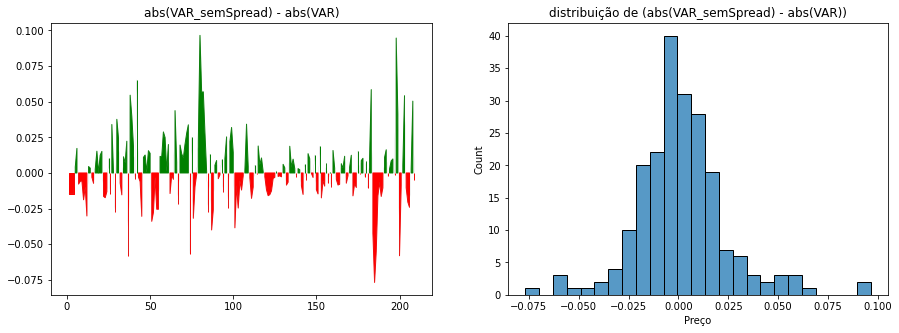

In [768]:
banco_escolhido = 'GoldmanSachs'
if True:

    print('Spread escolhido: ',spread.columns[-1])


    #Busca modelo e dataframe
    modelo1 , df_modelo = aplica_VAR(banco_escolhido)

    #ADICIONANDO O SPREAD
    spread = busca_spread(banco_escolhido=banco_escolhido).reset_index()

    df_modelo['Month '] = df_modelo.index
    df_modelo['Month '] = df_modelo['Month '].apply(lambda x: x.month)
    df_modelo['Year '] = df_modelo.index
    df_modelo['Year '] = df_modelo['Year '].apply(lambda x: x.year)
    df_modelo = pd.merge(df_modelo,spread,how='left',on=['Month ','Year '])
    df_modelo.drop(columns = ['Year ','Month '],inplace=True)

    diferienciacao = df_modelo.pct_change().dropna()
    df_modelo = diferienciacao
    
    modelo = VAR(diferienciacao)
    modelo_antigo = VAR(diferienciacao.drop(columns=spread.columns[-1])).fit(maxlags=3, ic='aic')
    modelo = modelo.fit(maxlags=3, ic='aic')


    #Summary Improvisado
    print( '-'*20 , f'\n {banco_escolhido} : Summary (VAR) \n','-'*20 )
    tabela = pd.DataFrame()
    tabela['Params'] = modelo.params['Preço']
    tabela['P-Valor'] = round(modelo.pvalues['Preço'],3)
    display(tabela)
    print('\n')


    #Comparando com um random-walk simples
    print( '-'*20 , f'\n {banco_escolhido} : Erro modelo VAR x Random-Walk \n','-'*20 )
    fig , ax = plt.subplots(1,2,figsize=(15,5))

    erro_rw = abs(modelo_antigo.fittedvalues['Preço'] - df_modelo['Preço']).fillna(method='bfill')
    erro_var = abs(modelo.fittedvalues['Preço'] - df_modelo['Preço']).fillna(method='bfill')


    ax[0].plot(erro_rw-erro_var,color='gray',lw=0.1)
    ax[0].fill_between(erro_var.index,0,(erro_rw-erro_var),(erro_rw-erro_var)>0,color='Green')
    ax[0].fill_between(erro_var.index,0,(erro_rw-erro_var),(erro_rw-erro_var)<0,color='Red')
    
    sns.histplot((erro_rw-erro_var),ax=ax[1])
    t_obs , p_valor = ttest_ind(erro_rw,erro_var)

    print('P-valor da comparação de média:',p_valor)
    ax[0].set_title('abs(VAR_semSpread) - abs(VAR)')
    ax[1].set_title('distribuição de (abs(VAR_semSpread) - abs(VAR))')

    plt.show()

-------------------- 
 MorganStanley : Summary (VAR) 
 --------------------


,Params,P-Valor
const,0.029774,0.077
L1.PX_TO_BOOK_RATIO,-0.480611,0.424
L1.PE_RATIO,0.033086,0.244
L1.EQY_WEIGHTED_AVG_PX,-0.198614,0.753
L1.FNCL_LVRG,0.372309,0.570
L1.NET_DEBT_TO_SHRHLDR_EQTY,-0.009820,0.904
L1.Preço,-0.140839,0.230
L1.3Y / 10Y,0.319291,0.162
L2.PX_TO_BOOK_RATIO,-0.651763,0.302
L2.PE_RATIO,0.034048,0.257




-------------------- 
 MorganStanley : Erro modelo VAR x Random-Walk 
 --------------------
P-valor da comparação de média: 0.9007733908931045


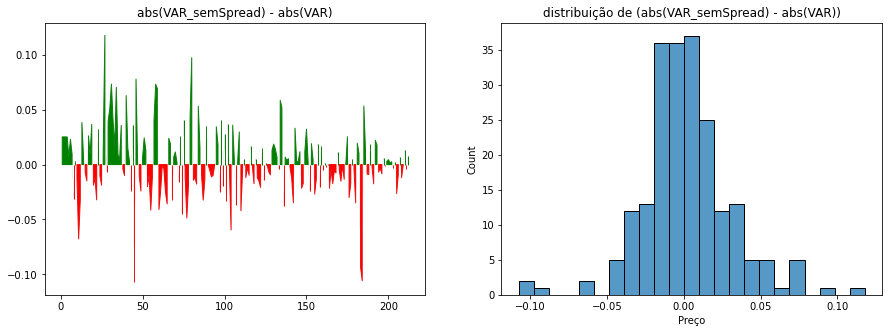

In [769]:
banco_escolhido = 'MorganStanley'
if True:
    print('Spread escolhido: ',spread.columns[-1])

    #Busca modelo e dataframe
    modelo1 , df_modelo = aplica_VAR(banco_escolhido)

    #ADICIONANDO O SPREAD
    spread = busca_spread(banco_escolhido=banco_escolhido).reset_index()

    df_modelo['Month '] = df_modelo.index
    df_modelo['Month '] = df_modelo['Month '].apply(lambda x: x.month)
    df_modelo['Year '] = df_modelo.index
    df_modelo['Year '] = df_modelo['Year '].apply(lambda x: x.year)
    df_modelo = pd.merge(df_modelo,spread,how='left',on=['Month ','Year '])
    df_modelo.drop(columns = ['Year ','Month '],inplace=True)

    diferienciacao = df_modelo.pct_change().dropna()
    df_modelo = diferienciacao
    
    modelo = VAR(diferienciacao)
    modelo_antigo = VAR(diferienciacao.drop(columns=spread.columns[-1])).fit(maxlags=3, ic='aic')
    modelo = modelo.fit(maxlags=3, ic='aic')


    #Summary Improvisado
    print( '-'*20 , f'\n {banco_escolhido} : Summary (VAR) \n','-'*20 )
    tabela = pd.DataFrame()
    tabela['Params'] = modelo.params['Preço']
    tabela['P-Valor'] = round(modelo.pvalues['Preço'],3)
    display(tabela)
    print('\n')


    #Comparando com um random-walk simples
    print( '-'*20 , f'\n {banco_escolhido} : Erro modelo VAR x Random-Walk \n','-'*20 )
    fig , ax = plt.subplots(1,2,figsize=(15,5))

    erro_rw = abs(modelo_antigo.fittedvalues['Preço'] - df_modelo['Preço']).fillna(method='bfill')
    erro_var = abs(modelo.fittedvalues['Preço'] - df_modelo['Preço']).fillna(method='bfill')


    ax[0].plot(erro_rw-erro_var,color='gray',lw=0.1)
    ax[0].fill_between(erro_var.index,0,(erro_rw-erro_var),(erro_rw-erro_var)>0,color='Green')
    ax[0].fill_between(erro_var.index,0,(erro_rw-erro_var),(erro_rw-erro_var)<0,color='Red')
    
    sns.histplot((erro_rw-erro_var),ax=ax[1])
    t_obs , p_valor = ttest_ind(erro_rw,erro_var)

    print('P-valor da comparação de média:',p_valor)
    ax[0].set_title('abs(VAR_semSpread) - abs(VAR)')
    ax[1].set_title('distribuição de (abs(VAR_semSpread) - abs(VAR))')

    plt.show()